# Noise-Based Machine Unlearning: A Comparative Study

**Author:** Eshaan  
**Institution:** Undergraduate Thesis  
**Date:** 2025

---

## Abstract

This notebook presents a comprehensive experimental study of noise-based machine unlearning strategies applied to neural network classifiers. Machine unlearning addresses the challenge of removing the influence of specific training data from a trained model without complete retraining—a capability increasingly mandated by regulations like GDPR's "right to be forgotten." 

We implement and evaluate five noise-based unlearning approaches: Gaussian noise injection, Laplacian noise injection, adaptive (magnitude-proportional) noise, layer-wise progressive noise, and gradient-based unlearning with noise. 

**Dataset Flexibility:** This notebook supports two modes via the `config.test` parameter:
- **Test Mode (test=True):** Uses a synthetic 4-class spiral dataset for controlled experiments with clear visualizations
- **Production Mode (test=False):** Uses the Adult Income dataset for real-world validation with binary classification

Our experiments use TabNet classifiers, designed specifically for tabular data. We evaluate each strategy across three dimensions: forgetting effectiveness (forget set accuracy should approach random guessing), utility preservation (retain set performance), and membership inference attack resistance.

---

## Table of Contents

1. [Introduction & Theoretical Background](#1-introduction)
2. [Environment Setup & Reproducibility](#2-setup)
3. [Dataset Generation & Exploration](#3-dataset)
4. [Baseline Model Training](#4-baseline)
5. [Unlearning Strategy Implementations](#5-strategies)
6. [Experimental Design: Forget Requests](#6-experiments)
7. [Comprehensive Evaluation](#7-evaluation)
8. [Hyperparameter Optimization](#8-optimization)
9. [Results Analysis & Visualization](#9-results)
10. [Conclusions & Future Work](#10-conclusions)
11. [References](#11-references)

---

<a id="1-introduction"></a>
## 1. Introduction & Theoretical Background

### 1.1 What is Machine Unlearning?

Machine unlearning refers to the process of removing the influence of specific training data points from a trained machine learning model. The naive approach—retraining the model from scratch on the remaining data—is computationally prohibitive for large models and datasets. Machine unlearning algorithms aim to achieve equivalent results with significantly less computation.

### 1.2 Why Noise-Based Approaches?

Noise-based unlearning offers several advantages:

- **No retraining required:** The original model's parameters are perturbed rather than recomputed
- **Theoretical guarantees:** Connections to differential privacy provide (ε,δ)-certified removal guarantees
- **Computational efficiency:** O(p) complexity where p is the number of parameters, versus O(n·p·e) for full retraining
- **Flexibility:** Can be applied post-hoc to any trained model

### 1.3 Theoretical Foundation

The theoretical basis for noise-based unlearning comes from Guo et al. (2020), who established **(ε,δ)-certified removal**. The key insight is that adding calibrated Gaussian noise to model parameters can mask the residual influence of removed data points, making the unlearned model statistically indistinguishable from a model retrained without that data.

For certified (ε,δ)-unlearning, the noise scale σ is computed as:

$$\sigma = \frac{\sqrt{2 \ln(1.25/\delta)} \cdot \text{sensitivity}}{\epsilon}$$

### 1.4 Evaluation Criteria

We evaluate unlearning quality across three dimensions:

1. **Forgetting Effectiveness:** Accuracy on forget set should approach random guessing (1/C for C classes = 25% for our 4-class problem)
2. **Utility Preservation:** Accuracy on retain set should remain high (target: >90%)
3. **Privacy Guarantee:** Membership Inference Attack success rate should approach 50% (random guessing)

---

<a id="2-setup"></a>
## 2. Environment Setup & Reproducibility

### 2.1 Import Libraries

We organize imports by category for clarity and maintainability.

In [26]:
# =============================================================================
# STANDARD LIBRARY IMPORTS
# =============================================================================
import copy
import json
import os
import time
import warnings
import zipfile
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Callable
from dataclasses import dataclass

# =============================================================================
# NUMERICAL & DATA PROCESSING
# =============================================================================
import numpy as np
from numpy import pi
import pandas as pd

# =============================================================================
# MACHINE LEARNING FRAMEWORKS
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# =============================================================================
# TABNET - SPECIALIZED TABULAR DATA ARCHITECTURE
# =============================================================================
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

# =============================================================================
# SCIKIT-LEARN - PREPROCESSING & EVALUATION
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    f1_score
)

# =============================================================================
# VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns

# =============================================================================
# PROGRESS TRACKING
# =============================================================================
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"  PyTorch version: {torch.__version__}")
print(f"  NumPy version: {np.__version__}")
print(f"  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ All libraries imported successfully
  PyTorch version: 2.7.1+cpu
  NumPy version: 2.3.1
  Device: CPU


### 2.2 Reproducibility Configuration

Setting random seeds ensures that experiments are reproducible across different runs. This is crucial for scientific validity and debugging.

In [27]:
# =============================================================================
# REPRODUCIBILITY CONFIGURATION
# =============================================================================
# All random states are explicitly set and documented

@dataclass
class ExperimentConfig:
    """Central configuration for all experiment parameters.
    
    Centralizing configuration improves reproducibility and makes
    it easy to modify experimental parameters in one place.
    """
    # Random seed for reproducibility
    seed: int = 42
    
    # Dataset selection
    test: bool = False  # If True, use synthetic spiral dataset; if False, use Adult Income dataset
    
    # Missing value handling strategy for Adult Income dataset
    # Options: 'drop' (simple) or 'impute_unknown' (recommended)
    missing_strategy: str = 'impute_unknown'  # Recommended: preserves information
    
    # Dataset parameters
    samples_per_class: int = 300
    num_classes: int = 4
    noise_std: float = 0.5  # Gaussian noise added to spiral coordinates
    test_size: float = 0.2
    
    # TabNet architecture parameters
    n_d: int = 8 if test else 64                    # Width of decision prediction layer, 8 for testing with 2D data, else 64
    n_a: int = 8 if test else 64                    # Width of attention embedding
    n_steps: int = 3 if test else 5                 # Number of decision steps, 3 for testing with 2D data, else 5-7
    gamma: float = 1.3 if test else 1.5             # Coefficient for feature reusag, 1.3 for testing with 2D data, else 1.5
    lambda_sparse: float = 1e-4 if test else 1e-3   # Sparsity regularization, 1e-4 for testing with 2D data, else 1e-3
    
    # Training parameters
    max_epochs: int = 100 if test else 200    # 100 for testing with 2D data, else 200
    patience: int = 20 if test else 200       # 100 for testing with 2D data, else 200
    batch_size: int = 256 if test else 1024   # 256 for testing with 2D data, else 1024
    virtual_batch_size: int = 128
    learning_rate: float = 2e-2
    
    # Evaluation thresholds
    target_forget_accuracy: float = 0.25  # Random guessing for 4 classes
    target_retain_accuracy: float = 0.90  # Minimum acceptable retention
    target_mia_auc: float = 0.50          # Random guessing for MIA


def set_all_seeds(seed: int) -> None:
    """Set random seeds for all libraries to ensure reproducibility.
    
    Args:
        seed: Integer seed value for random number generators
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # For deterministic operations (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Initialize configuration
config = ExperimentConfig()

# Set seeds globally
set_all_seeds(config.seed)

# Create numpy random generator (modern API)
rng = np.random.default_rng(config.seed)

print("✓ Reproducibility configured")
print(f"  Global seed: {config.seed}")
print(f"  Dataset mode: {'TEST (Spiral)' if config.test else 'PRODUCTION (Adult Income)'}")
if not config.test:
    print(f"  Missing value strategy: {config.missing_strategy}")
print(f"  Target forget accuracy: {config.target_forget_accuracy:.0%}")
print(f"  Target retain accuracy: {config.target_retain_accuracy:.0%}")

✓ Reproducibility configured
  Global seed: 42
  Dataset mode: PRODUCTION (Adult Income)
  Missing value strategy: impute_unknown
  Target forget accuracy: 25%
  Target retain accuracy: 90%


### 2.3 Visualization Style Configuration

In [28]:
# =============================================================================
# VISUALIZATION CONFIGURATION
# =============================================================================
# Consistent styling across all plots for professional presentation

# Set global style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Color scheme for spiral classes (colorblind-friendly)
CLASS_COLORS = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6']  # Red, Blue, Green, Purple
CLASS_CMAP = ListedColormap(CLASS_COLORS)

# Figure defaults
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'sans-serif'
})

print("✓ Visualization style configured")

✓ Visualization style configured


---

<a id="3-dataset"></a>
## 3. Dataset Loading & Exploration

Based on the `config.test` parameter, we'll either load:
- **Test Mode (test=True):** Synthetic multi-class spiral dataset for controlled experiments
- **Production Mode (test=False):** Adult Income dataset for real-world validation

### 3.1 Dataset Loading

The spiral dataset is useful for testing because:
- **Non-linear separability:** Spirals require complex decision boundaries that neural networks excel at learning
- **Visual interpretability:** Easy to visualize how unlearning affects decision regions
- **Controlled complexity:** We can adjust noise and class overlap
- **Clear class structure:** Each spiral arm represents a distinct class, making forgetting a specific class meaningful

The Adult Income dataset provides real-world validation with:
- **Real-world complexity:** Actual census data with mixed feature types
- **Industry relevance:** Common benchmark for fairness and privacy research
- **Binary classification:** Predicting whether income exceeds $50K/year

In [29]:
def generate_spiral_dataset(
    n_samples_per_class: int,
    n_classes: int,
    noise_std: float,
    rng: np.random.Generator
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a multi-class Archimedean spiral dataset.
    
    The spirals are generated using the parametric equations:
        r = a + b*θ  (Archimedean spiral)
        x = r * cos(θ + offset)
        y = r * sin(θ + offset)
    
    Each class is a spiral arm rotated by (2π/n_classes) from the previous.
    
    Args:
        n_samples_per_class: Number of points per spiral arm
        n_classes: Number of spiral arms (classes)
        noise_std: Standard deviation of Gaussian noise added to coordinates
        rng: NumPy random generator for reproducibility
    
    Returns:
        X: Feature matrix of shape (n_samples_per_class * n_classes, 2)
        y: Label vector of shape (n_samples_per_class * n_classes,)
    """
    all_points = []
    all_labels = []
    
    for class_idx in range(n_classes):
        # Generate theta values with square root transformation
        # This creates more uniform distribution along the spiral
        theta = np.sqrt(rng.random(n_samples_per_class)) * 2 * pi
        
        # Calculate rotation offset for this spiral arm
        # Evenly distributes spirals around the origin
        angle_offset = (2 * pi * class_idx) / n_classes
        
        # Archimedean spiral: r = a + b*θ
        # We use r = 2θ + π to start spirals away from origin
        radius = 2 * theta + pi
        
        # Convert polar to Cartesian coordinates with rotation
        x = np.cos(theta + angle_offset) * radius
        y = np.sin(theta + angle_offset) * radius
        
        # Stack into coordinate pairs
        points = np.column_stack([x, y])
        
        # Add Gaussian noise for realism and overlap
        points += rng.standard_normal((n_samples_per_class, 2)) * noise_std
        
        all_points.append(points)
        all_labels.append(np.full(n_samples_per_class, class_idx))
    
    # Combine all classes
    X = np.vstack(all_points)
    y = np.concatenate(all_labels)
    
    # Shuffle to remove ordering bias
    shuffle_idx = rng.permutation(len(y))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    return X, y


# =============================================================================
# DATASET LOADING LOGIC
# =============================================================================

if config.test:
    # =========================================================================
    # TEST MODE: Load or generate spiral dataset
    # =========================================================================
    print("="*60)
    print("LOADING SPIRAL DATASET (TEST MODE)")
    print("="*60)
    
    # For now, generate the dataset (can be modified to load from file later)
    X_full_spiral, y_full_spiral = generate_spiral_dataset(
        n_samples_per_class=config.samples_per_class,
        n_classes=config.num_classes,
        noise_std=config.noise_std,
        rng=rng
    )
    
    # Use spiral data as the main dataset
    X_full = X_full_spiral
    y_full = y_full_spiral
    
    print(f"Total samples: {len(y_full):,}")
    print(f"Feature dimensions: {X_full.shape[1]}")
    print(f"Number of classes: {config.num_classes}")
    print(f"\nClass distribution:")
    for i in range(config.num_classes):
        count = np.sum(y_full == i)
        print(f"  Class {i}: {count:,} samples ({count/len(y_full):.1%})")
    
else:
    # =========================================================================
    # PRODUCTION MODE: Load Adult Income dataset
    # =========================================================================
    print("="*60)
    print("LOADING ADULT INCOME DATASET (PRODUCTION MODE)")
    print("="*60)
    
    # Path to the dataset
    dataset_path = Path("datasets/adult.csv.zip")
    
    # Load from zip file
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        # Get the CSV filename (assuming there's only one CSV in the zip)
        csv_filename = [name for name in zip_ref.namelist() if name.endswith('.csv')][0]
        
        # Read the CSV directly from the zip
        with zip_ref.open(csv_filename) as csv_file:
            df_adult_raw = pd.read_csv(csv_file)
    
    print(f"Raw dataset loaded: {df_adult_raw.shape[0]:,} samples, {df_adult_raw.shape[1]} features")
    print("\nFirst few rows:")
    print(df_adult_raw.head())
    print("\nDataset info:")
    print(df_adult_raw.info())
    
    # Placeholder: X_full and y_full will be created after preprocessing
    print("\n⚠️  Data preprocessing required - will be done in subsequent cells")

LOADING ADULT INCOME DATASET (PRODUCTION MODE)
Raw dataset loaded: 48,842 samples, 15 features

First few rows:
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4      

### 3.2 Adult Income Dataset: Exploration

This section only runs when `config.test = False`. We explore the Adult Income dataset to understand its structure, features, and quality.

In [30]:
if not config.test:
    # =========================================================================
    # ADULT INCOME: DETAILED EXPLORATION
    # =========================================================================
    
    print("="*80)
    print("ADULT INCOME DATASET: EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    # Basic statistics
    print("\n1. DATASET SHAPE")
    print("-"*80)
    print(f"   Rows: {df_adult_raw.shape[0]:,}")
    print(f"   Columns: {df_adult_raw.shape[1]}")
    
    # Column names and types
    print("\n2. COLUMN INFORMATION")
    print("-"*80)
    for idx, (col, dtype) in enumerate(zip(df_adult_raw.columns, df_adult_raw.dtypes), 1):
        null_count = df_adult_raw[col].isnull().sum()
        null_pct = (null_count / len(df_adult_raw)) * 100
        unique_count = df_adult_raw[col].nunique()
        print(f"   {idx:2d}. {col:20s} | Type: {str(dtype):10s} | Unique: {unique_count:6,} | "
              f"Nulls: {null_count:5,} ({null_pct:5.2f}%)")
    
    # Check for missing values (often encoded as '?' in Adult dataset)
    print("\n3. MISSING VALUES (including '?' encoding)")
    print("-"*80)
    for col in df_adult_raw.columns:
        if df_adult_raw[col].dtype == 'object':
            missing_count = (df_adult_raw[col] == ' ?').sum() + df_adult_raw[col].isnull().sum()
        else:
            missing_count = df_adult_raw[col].isnull().sum()
        
        if missing_count > 0:
            pct = (missing_count / len(df_adult_raw)) * 100
            print(f"   {col:20s}: {missing_count:6,} ({pct:5.2f}%)")
    
    # Target variable distribution
    if 'income' in df_adult_raw.columns or 'Income' in df_adult_raw.columns:
        target_col = 'income' if 'income' in df_adult_raw.columns else 'Income'
        print(f"\n4. TARGET VARIABLE DISTRIBUTION ({target_col})")
        print("-"*80)
        target_dist = df_adult_raw[target_col].value_counts()
        for val, count in target_dist.items():
            pct = (count / len(df_adult_raw)) * 100
            print(f"   {val:20s}: {count:6,} ({pct:5.2f}%)")
    
    # Numerical features summary
    print("\n5. NUMERICAL FEATURES SUMMARY")
    print("-"*80)
    numerical_cols = df_adult_raw.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(df_adult_raw[numerical_cols].describe())
    else:
        print("   No numerical columns detected")
else:
    print("⏩ Skipping Adult Income exploration (TEST mode active)")


ADULT INCOME DATASET: EXPLORATORY DATA ANALYSIS

1. DATASET SHAPE
--------------------------------------------------------------------------------
   Rows: 48,842
   Columns: 15

2. COLUMN INFORMATION
--------------------------------------------------------------------------------
    1. age                  | Type: int64      | Unique:     74 | Nulls:     0 ( 0.00%)
    2. workclass            | Type: object     | Unique:      9 | Nulls:     0 ( 0.00%)
    3. fnlwgt               | Type: int64      | Unique: 28,523 | Nulls:     0 ( 0.00%)
    4. education            | Type: object     | Unique:     16 | Nulls:     0 ( 0.00%)
    5. educational-num      | Type: int64      | Unique:     16 | Nulls:     0 ( 0.00%)
    6. marital-status       | Type: object     | Unique:      7 | Nulls:     0 ( 0.00%)
    7. occupation           | Type: object     | Unique:     15 | Nulls:     0 ( 0.00%)
    8. relationship         | Type: object     | Unique:      6 | Nulls:     0 ( 0.00%)
    9. race   

### 3.3 Adult Income Dataset: Visualizations

Visual exploration helps us understand feature distributions and relationships.


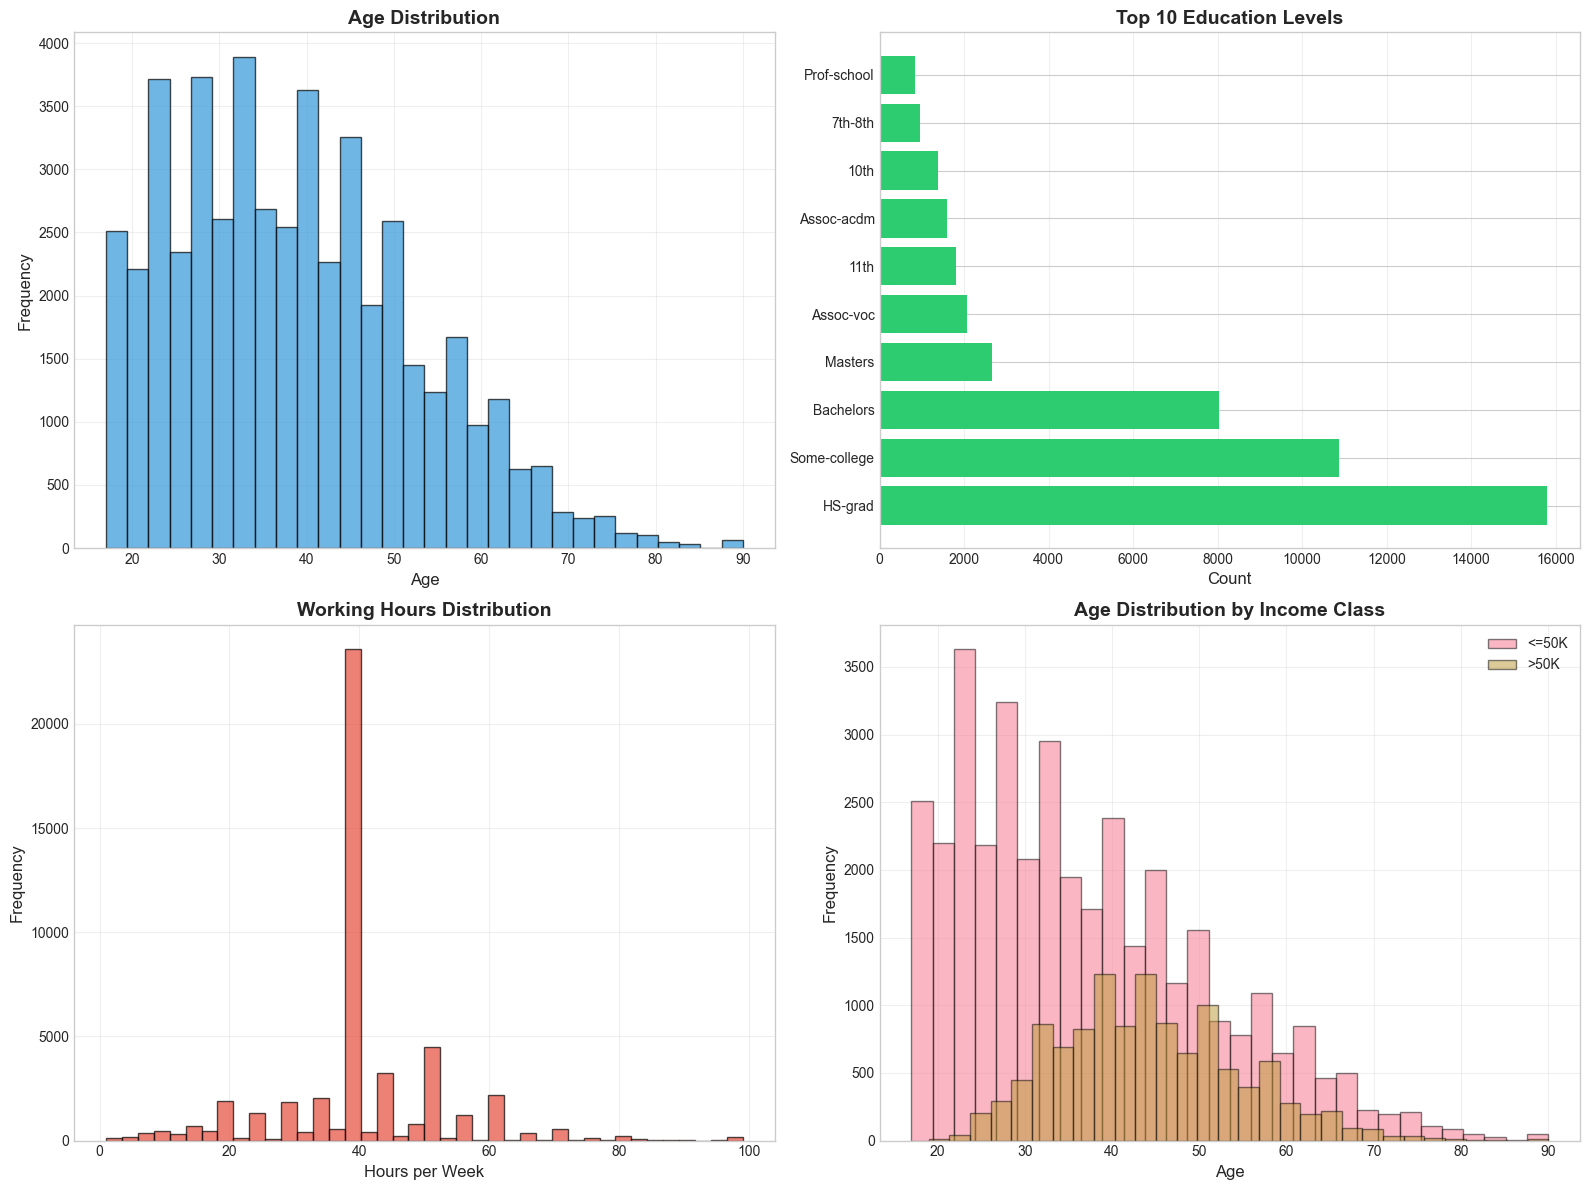


✓ Visualizations complete


In [31]:
if not config.test:
    # =========================================================================
    # ADULT INCOME: VISUALIZATIONS
    # =========================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Age distribution
    axes[0, 0].hist(df_adult_raw['age'] if 'age' in df_adult_raw.columns else [], 
                    bins=30, edgecolor='black', alpha=0.7, color='#3498DB')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Age Distribution', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Education level (if present)
    if 'education' in df_adult_raw.columns:
        edu_counts = df_adult_raw['education'].value_counts().head(10)
        axes[0, 1].barh(range(len(edu_counts)), edu_counts.values, color='#2ECC71')
        axes[0, 1].set_yticks(range(len(edu_counts)))
        axes[0, 1].set_yticklabels(edu_counts.index)
        axes[0, 1].set_xlabel('Count')
        axes[0, 1].set_title('Top 10 Education Levels', fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Hours per week distribution
    if 'hours-per-week' in df_adult_raw.columns or 'hours_per_week' in df_adult_raw.columns:
        hours_col = 'hours-per-week' if 'hours-per-week' in df_adult_raw.columns else 'hours_per_week'
        axes[1, 0].hist(df_adult_raw[hours_col], bins=40, edgecolor='black', 
                       alpha=0.7, color='#E74C3C')
        axes[1, 0].set_xlabel('Hours per Week')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Working Hours Distribution', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Income distribution by age
    if 'income' in df_adult_raw.columns or 'Income' in df_adult_raw.columns:
        target_col = 'income' if 'income' in df_adult_raw.columns else 'Income'
        age_col = 'age' if 'age' in df_adult_raw.columns else 'Age'
        
        for income_class in df_adult_raw[target_col].unique():
            subset = df_adult_raw[df_adult_raw[target_col] == income_class][age_col]
            axes[1, 1].hist(subset, bins=30, alpha=0.5, label=str(income_class), edgecolor='black')
        
        axes[1, 1].set_xlabel('Age')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Age Distribution by Income Class', fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualizations complete")
else:
    print("⏩ Skipping Adult Income visualizations (TEST mode active)")


### 3.4 Adult Income Dataset: Data Cleaning & Preprocessing

We need to clean and preprocess the Adult Income dataset to make it suitable for TabNet training.

**Important Notes:**
- **`fnlwgt` (Final Weight)**: This column represents the sampling weight from the US Census - the number of people in the population that each record represents. It has **no predictive value** for income classification and will be dropped.
- **Missing Values**: The Adult Income dataset encodes missing values as `'?'` (question marks) rather than NaN/null. We detect and handle these using the strategy specified in `config.missing_strategy`.

**Missing Value Strategies:**
1. **`'drop'`**: Remove all rows with missing values (simplest, loses ~7-8% of data, ~3,000-4,000 rows)
2. **`'impute_unknown'`** (RECOMMENDED): Create "Unknown" category - preserves all samples and the information that data was missing, which is often meaningful in census data (e.g., self-employed, retired, or declined to answer)


In [32]:
if not config.test:
    # =========================================================================
    # ADULT INCOME: DATA CLEANING
    # =========================================================================
    
    print("="*80)
    print("ADULT INCOME DATASET: DATA CLEANING & PREPROCESSING")
    print("="*80)
    
    df_adult = df_adult_raw.copy()
    
    # Step 1: Strip whitespace from all string columns
    print("\n1. CLEANING STRING COLUMNS")
    print("-"*80)
    for col in df_adult.columns:
        if df_adult[col].dtype == 'object':
            df_adult[col] = df_adult[col].str.strip()
            print(f"   ✓ Stripped whitespace from '{col}'")
    
    # Step 2: Drop fnlwgt column (sampling weight - not predictive)
    print("\n2. DROPPING NON-PREDICTIVE COLUMNS")
    print("-"*80)
    if 'fnlwgt' in df_adult.columns:
        df_adult = df_adult.drop(columns=['fnlwgt'])
        print(f"   ✓ Dropped 'fnlwgt' (sampling weight, not predictive for income)")
    else:
        print(f"   ⚠️  'fnlwgt' column not found")
    
    # Step 3: Handle missing values (encoded as '?')
    print("\n3. HANDLING MISSING VALUES")
    print("-"*80)
    
    # First, check for '?' values BEFORE replacing
    print("   Checking for '?' encoded missing values...")
    question_mark_counts = {}
    for col in df_adult.columns:
        if df_adult[col].dtype == 'object':
            count = (df_adult[col] == '?').sum()
            if count > 0:
                question_mark_counts[col] = count
    
    if len(question_mark_counts) > 0:
        print(f"\n   Found '?' values in {len(question_mark_counts)} columns:")
        for col, count in question_mark_counts.items():
            pct = (count / len(df_adult)) * 100
            print(f"      - {col}: {count:,} ({pct:.2f}%)")
    else:
        print("   ✓ No '?' values found")
    
    # Handle missing values based on strategy
    print(f"\n   Strategy: {config.missing_strategy}")
    
    if config.missing_strategy == 'drop':
        # STRATEGY 1: Drop rows with missing values (simple but loses data)
        df_adult = df_adult.replace('?', np.nan)
        before_count = len(df_adult)
        df_adult = df_adult.dropna()
        after_count = len(df_adult)
        dropped_count = before_count - after_count
        print(f"   ✓ Dropped {dropped_count:,} rows with missing values")
        print(f"   ✓ Dataset shape: {df_adult.shape[0]:,} rows, {df_adult.shape[1]} columns")
        
    elif config.missing_strategy == 'impute_unknown':
        # STRATEGY 2: Create "Unknown" category (RECOMMENDED - preserves all data)
        for col in question_mark_counts.keys():
            df_adult[col] = df_adult[col].replace('?', 'Unknown')
            print(f"      → Created 'Unknown' category for '{col}'")
        print(f"   ✓ Missing values marked as 'Unknown' (preserves information)")
        print(f"   ✓ Dataset shape: {df_adult.shape[0]:,} rows, {df_adult.shape[1]} columns")
        
    else:
        raise ValueError(f"Unknown missing_strategy: '{config.missing_strategy}'. "
                        f"Valid options: 'drop', 'impute_unknown'")
    
    # Step 4: Identify target column
    print("\n4. IDENTIFYING TARGET VARIABLE")
    print("-"*80)
    
    # Common column names for target in Adult dataset
    target_candidates = ['income', 'Income', 'salary', 'Salary', 'class', 'income_bracket']
    target_col = None
    
    for candidate in target_candidates:
        if candidate in df_adult.columns:
            target_col = candidate
            break
    
    if target_col is None:
        # If not found, assume last column is target
        target_col = df_adult.columns[-1]
        print(f"   ⚠️  Target column not explicitly identified, using last column: '{target_col}'")
    else:
        print(f"   ✓ Target column: '{target_col}'")
    
    # Show unique values before encoding
    print(f"\n   Target values before encoding: {sorted(df_adult[target_col].unique())}")
    
    # Convert target to binary (0/1)
    # Map income to binary (assuming '>50K' or '<=50K' format)
    target_mapping = {}
    unique_targets = df_adult[target_col].unique()
    
    for val in unique_targets:
        val_str = str(val).strip()
        if '>' in val_str or '50K' in val_str and '>' in val_str:
            target_mapping[val] = 1  # High income
        else:
            target_mapping[val] = 0  # Low income
    
    df_adult[target_col] = df_adult[target_col].map(target_mapping)
    
    print(f"   ✓ Target mapping: {target_mapping}")
    print(f"   ✓ Class distribution after encoding:")
    for class_val, count in sorted(df_adult[target_col].value_counts().items()):
        pct = (count / len(df_adult)) * 100
        class_label = "High income (>50K)" if class_val == 1 else "Low income (≤50K)"
        print(f"      - Class {class_val} ({class_label}): {count:,} ({pct:.2f}%)")
    
    print("\n✓ Data cleaning complete")
else:
    print("⏩ Skipping Adult Income cleaning (TEST mode active)")


ADULT INCOME DATASET: DATA CLEANING & PREPROCESSING

1. CLEANING STRING COLUMNS
--------------------------------------------------------------------------------
   ✓ Stripped whitespace from 'workclass'
   ✓ Stripped whitespace from 'education'
   ✓ Stripped whitespace from 'marital-status'
   ✓ Stripped whitespace from 'occupation'
   ✓ Stripped whitespace from 'relationship'
   ✓ Stripped whitespace from 'race'
   ✓ Stripped whitespace from 'gender'
   ✓ Stripped whitespace from 'native-country'
   ✓ Stripped whitespace from 'income'

2. DROPPING NON-PREDICTIVE COLUMNS
--------------------------------------------------------------------------------
   ✓ Dropped 'fnlwgt' (sampling weight, not predictive for income)

3. HANDLING MISSING VALUES
--------------------------------------------------------------------------------
   Checking for '?' encoded missing values...

   Found '?' values in 3 columns:
      - workclass: 2,799 (5.73%)
      - occupation: 2,809 (5.75%)
      - native-co

In [33]:
if not config.test:
    # =========================================================================
    # ADULT INCOME: FEATURE ENCODING
    # =========================================================================
    
    print("\n" + "="*80)
    print("FEATURE ENCODING")
    print("="*80)
    
    # Separate features and target
    y_adult = df_adult[target_col].values
    X_adult_df = df_adult.drop(columns=[target_col])
    
    print(f"\nFeatures shape: {X_adult_df.shape}")
    print(f"Target shape: {y_adult.shape}")
    
    # Identify categorical and numerical columns
    categorical_cols = X_adult_df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_adult_df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")
    print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
    
    # Encode categorical variables using Label Encoding
    # (TabNet can handle categorical indices directly)
    print("\nEncoding categorical variables...")
    
    from sklearn.preprocessing import LabelEncoder
    
    X_adult_encoded = X_adult_df.copy()
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_adult_encoded[col] = le.fit_transform(X_adult_df[col])
        label_encoders[col] = le
        print(f"   ✓ {col}: {len(le.classes_)} unique values → [0, {len(le.classes_)-1}]")
    
    # Convert to numpy array
    X_adult = X_adult_encoded.values.astype(np.float32)
    y_adult = y_adult.astype(np.int64)
    
    # Update config for binary classification
    config.num_classes = 2
    config.target_forget_accuracy = 0.50  # Random guessing for binary
    
    print(f"\n✓ Encoding complete")
    print(f"   Final feature matrix shape: {X_adult.shape}")
    print(f"   Final target shape: {y_adult.shape}")
    print(f"   Number of classes updated: {config.num_classes}")
    
    # Assign to X_full and y_full for downstream processing
    X_full = X_adult
    y_full = y_adult
    
    print(f"\n✓ Dataset ready for training!")
    print(f"   Total samples: {len(y_full):,}")
    print(f"   Feature dimensions: {X_full.shape[1]}")
    print(f"   Number of classes: {config.num_classes}")
    
else:
    print("⏩ Skipping Adult Income encoding (TEST mode active)")



FEATURE ENCODING

Features shape: (48842, 13)
Target shape: (48842,)

Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Numerical features (5): ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Encoding categorical variables...
   ✓ workclass: 9 unique values → [0, 8]
   ✓ education: 16 unique values → [0, 15]
   ✓ marital-status: 7 unique values → [0, 6]
   ✓ occupation: 15 unique values → [0, 14]
   ✓ relationship: 6 unique values → [0, 5]
   ✓ race: 5 unique values → [0, 4]
   ✓ gender: 2 unique values → [0, 1]
   ✓ native-country: 42 unique values → [0, 41]

✓ Encoding complete
   Final feature matrix shape: (48842, 13)
   Final target shape: (48842,)
   Number of classes updated: 2

✓ Dataset ready for training!
   Total samples: 48,842
   Feature dimensions: 13
   Number of classes: 2


### 3.5 Dataset Visualization (Test Mode Only)

For the spiral dataset, we visualize the data to understand the pattern and class separation.


In [34]:
def plot_spiral_dataset(
    X: np.ndarray, 
    y: np.ndarray, 
    title: str = "Spiral Dataset",
    highlight_class: Optional[int] = None,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Create a scatter plot of the spiral dataset.
    
    Args:
        X: Feature matrix (n_samples, 2)
        y: Labels (n_samples,)
        title: Plot title
        highlight_class: If specified, this class is highlighted with larger markers
        ax: Matplotlib axes to plot on (creates new figure if None)
    
    Returns:
        The matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    for class_idx in range(config.num_classes):
        mask = y == class_idx
        
        # Determine marker properties based on highlighting
        if highlight_class is not None and class_idx == highlight_class:
            size, alpha, edge = 80, 0.9, 'black'
        else:
            size, alpha, edge = 40, 0.6, 'none'
        
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=CLASS_COLORS[class_idx],
            label=f'Class {class_idx}',
            s=size,
            alpha=alpha,
            edgecolors=edge,
            linewidths=0.5
        )
    
    ax.set_xlabel('Feature X₁')
    ax.set_ylabel('Feature X₂')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return ax


if config.test:
    # Visualize the spiral dataset (only in test mode)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Full dataset
    plot_spiral_dataset(X_full, y_full, "Complete Spiral Dataset", ax=axes[0])
    
    # Right: Highlight Class 2 (our primary forget target)
    plot_spiral_dataset(X_full, y_full, "Class 2 Highlighted (Primary Forget Target)", 
                       highlight_class=2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Class 2 (green) will be our primary target for complete class unlearning.")
else:
    print("⏩ Skipping spiral visualization (Adult Income dataset loaded)")

⏩ Skipping spiral visualization (Adult Income dataset loaded)


### 3.6 Train/Test Split and Normalization

This section applies to both datasets (spiral and adult income).

In [35]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================
# Stratified split ensures balanced class distribution in both sets

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=config.test_size,
    random_state=config.seed,
    stratify=y_full  # Maintain class proportions
)

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Training set: {len(y_train):,} samples")
print(f"Test set: {len(y_test):,} samples")

# =============================================================================
# FEATURE NORMALIZATION
# =============================================================================
# StandardScaler: z = (x - μ) / σ
# Fitted ONLY on training data to prevent data leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform
X_test_scaled = scaler.transform(X_test)        # Transform only (no fitting!)

print(f"\nNormalization statistics (from training set):")
if X_train.shape[1] <= 5:
    # For small number of features, show all
    print(f"  Mean: {scaler.mean_}")
    print(f"  Std:  {scaler.scale_}")
else:
    # For many features, show summary
    print(f"  Mean: min={scaler.mean_.min():.4f}, max={scaler.mean_.max():.4f}")
    print(f"  Std:  min={scaler.scale_.min():.4f}, max={scaler.scale_.max():.4f}")

# Verify normalization
print(f"\nVerification (training set after scaling):")
print(f"  Mean: ~{X_train_scaled.mean():.6f} (should be ≈0)")
print(f"  Std:  ~{X_train_scaled.std():.6f} (should be ≈1)")

TRAIN/TEST SPLIT
Training set: 39,073 samples
Test set: 9,769 samples

Normalization statistics (from training set):
  Mean: min=0.6690, max=1057.4686
  Std:  min=0.4706, max=7332.4105

Verification (training set after scaling):
  Mean: ~-0.000000 (should be ≈0)
  Std:  ~1.000000 (should be ≈1)


### 3.7 Visualize Normalized Data (Test Mode Only)

For 2D spiral data, we can visualize the normalized train/test splits.

In [36]:
if config.test:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training set
    plot_spiral_dataset(X_train_scaled, y_train, 
                       f"Training Set (n={len(y_train)})", ax=axes[0])
    
    # Test set
    plot_spiral_dataset(X_test_scaled, y_test, 
                       f"Test Set (n={len(y_test)})", ax=axes[1])
    
    plt.tight_layout()
    plt.show()
else:
    print("⏩ Skipping visualization (Adult Income has >2 dimensions)")

⏩ Skipping visualization (Adult Income has >2 dimensions)


---

<a id="4-baseline"></a>
## 4. Baseline Model Training

### 4.1 Why TabNet?

TabNet (Arik & Pfister, 2021) is a deep learning architecture specifically designed for tabular data. Key advantages include:

- **Interpretability:** Built-in attention mechanism shows which features are used for each decision
- **Sequential attention:** Decision-tree-like processing with learnable feature selection
- **No preprocessing required:** Handles numerical features directly
- **State-of-the-art performance:** Often matches or exceeds gradient boosting on tabular benchmarks

For machine unlearning research, TabNet provides clear access to network parameters through its PyTorch implementation, making noise injection straightforward.

In [37]:
def create_tabnet_model(config: ExperimentConfig, verbose: int = 1) -> TabNetClassifier:
    """
    Create a TabNet classifier with standardized configuration.
    
    Args:
        config: Experiment configuration dataclass
        verbose: Verbosity level (0=silent, 1=progress bar)
    
    Returns:
        Initialized TabNetClassifier (not yet fitted)
    """
    model = TabNetClassifier(
        # Architecture parameters
        n_d=config.n_d,                    # Decision prediction layer width
        n_a=config.n_a,                    # Attention embedding width
        n_steps=config.n_steps,            # Number of decision steps
        gamma=config.gamma,                # Feature reusage coefficient
        lambda_sparse=config.lambda_sparse, # Sparsity regularization
        
        # Optimizer configuration
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': config.learning_rate},
        
        # Learning rate scheduler
        scheduler_params={'step_size': 50, 'gamma': 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        
        # Mask type (entmax for sparse attention)
        mask_type='entmax',
        
        # Output control
        verbose=verbose
    )
    
    return model


def train_tabnet_model(
    model: TabNetClassifier,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray = None,
    y_val: np.ndarray = None,
    config: ExperimentConfig = None
) -> TabNetClassifier:
    """
    Train a TabNet model with early stopping.
    
    Args:
        model: Initialized TabNetClassifier
        X_train: Training features
        y_train: Training labels
        X_val: Validation features (optional)
        y_val: Validation labels (optional)
        config: Experiment configuration (optional)
    
    Returns:
        Trained TabNetClassifier
    """
    if config is None:
        config = ExperimentConfig()
    
    # Prepare validation set if provided
    eval_set = [(X_val, y_val)] if X_val is not None else None
    
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        max_epochs=config.max_epochs,
        patience=config.patience,
        batch_size=config.batch_size,
        virtual_batch_size=config.virtual_batch_size
    )
    
    return model


print("✓ Model creation functions defined")

✓ Model creation functions defined


### 4.2 Train the Baseline Model

In [38]:
print("="*60)
print("TRAINING BASELINE TABNET MODEL")
print("="*60)

# Create and train the model
start_time = time.time()

tabnet_model = create_tabnet_model(config, verbose=1)
tabnet_model = train_tabnet_model(
    tabnet_model,
    X_train_scaled, y_train.astype(int),
    X_test_scaled, y_test.astype(int),
    config
)

training_time = time.time() - start_time

# Evaluate baseline performance
y_train_pred = tabnet_model.predict(X_train_scaled)
y_test_pred = tabnet_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n{'='*60}")
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print(f"Training time: {training_time:.2f} seconds")
print(f"Training accuracy: {train_acc:.4f} ({train_acc:.1%})")
print(f"Test accuracy: {test_acc:.4f} ({test_acc:.1%})")

# Store baseline metrics for later comparison
baseline_metrics = {
    'train_acc': train_acc,
    'test_acc': test_acc,
    'training_time': training_time
}

TRAINING BASELINE TABNET MODEL
epoch 0  | loss: 0.49027 | val_0_auc: 0.87588 |  0:00:07s
epoch 1  | loss: 0.36964 | val_0_auc: 0.87955 |  0:00:14s
epoch 2  | loss: 0.34968 | val_0_auc: 0.89148 |  0:00:22s
epoch 3  | loss: 0.3426  | val_0_auc: 0.89586 |  0:00:29s
epoch 4  | loss: 0.34067 | val_0_auc: 0.89158 |  0:00:36s
epoch 5  | loss: 0.33659 | val_0_auc: 0.89433 |  0:00:43s
epoch 6  | loss: 0.33731 | val_0_auc: 0.89665 |  0:00:50s
epoch 7  | loss: 0.33639 | val_0_auc: 0.90026 |  0:00:57s
epoch 8  | loss: 0.32785 | val_0_auc: 0.90321 |  0:01:05s
epoch 9  | loss: 0.3281  | val_0_auc: 0.90302 |  0:01:12s
epoch 10 | loss: 0.32755 | val_0_auc: 0.90123 |  0:01:19s
epoch 11 | loss: 0.3289  | val_0_auc: 0.90278 |  0:01:26s
epoch 12 | loss: 0.32331 | val_0_auc: 0.9043  |  0:01:33s
epoch 13 | loss: 0.32178 | val_0_auc: 0.90321 |  0:01:39s
epoch 14 | loss: 0.32319 | val_0_auc: 0.90221 |  0:01:46s
epoch 15 | loss: 0.32617 | val_0_auc: 0.9019  |  0:01:53s
epoch 16 | loss: 0.32862 | val_0_auc: 0.9

### 4.3 Baseline Model Evaluation

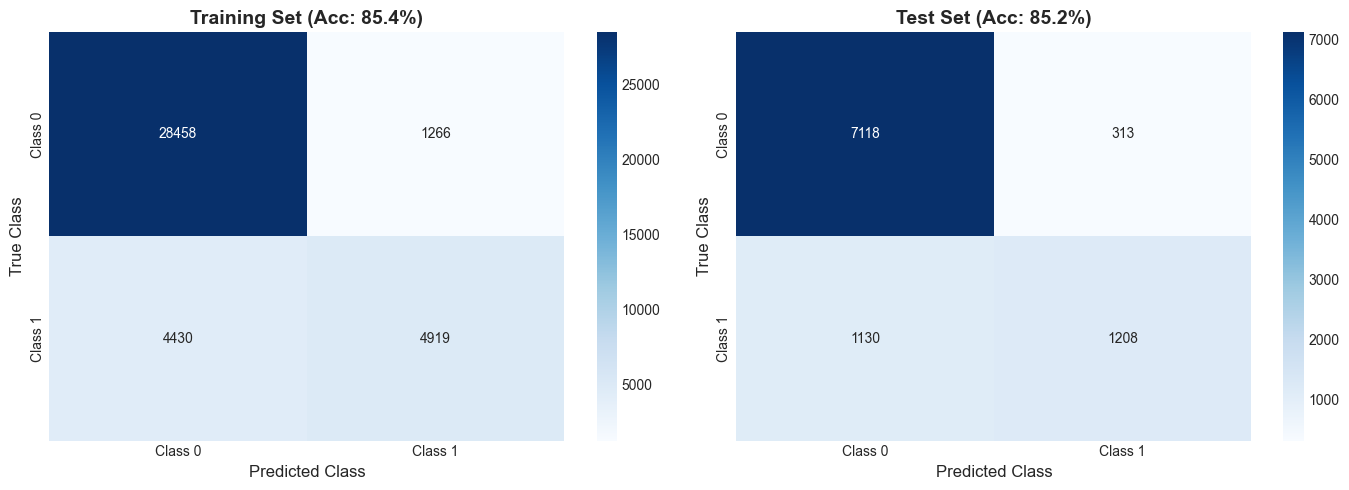


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.86      0.96      0.91      7431
     Class 1       0.79      0.52      0.63      2338

    accuracy                           0.85      9769
   macro avg       0.83      0.74      0.77      9769
weighted avg       0.85      0.85      0.84      9769



In [39]:
def plot_confusion_matrix(
    y_true: np.ndarray, 
    y_pred: np.ndarray,
    title: str = "Confusion Matrix",
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Plot a confusion matrix with annotations.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        title: Plot title
        ax: Matplotlib axes (creates new if None)
    
    Returns:
        Matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[f'Class {i}' for i in range(config.num_classes)],
        yticklabels=[f'Class {i}' for i in range(config.num_classes)],
        ax=ax
    )
    
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title(title, fontweight='bold')
    
    return ax


# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_confusion_matrix(y_train, y_train_pred, 
                     f"Training Set (Acc: {train_acc:.1%})", ax=axes[0])
plot_confusion_matrix(y_test, y_test_pred, 
                     f"Test Set (Acc: {test_acc:.1%})", ax=axes[1])

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                           target_names=[f'Class {i}' for i in range(config.num_classes)]))

In [40]:
def plot_decision_boundary(
    model: TabNetClassifier,
    X: np.ndarray,
    y: np.ndarray,
    title: str = "Decision Boundary",
    resolution: int = 200,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Visualize the decision boundary of a classifier.
    
    Creates a mesh grid over the feature space and colors each
    region according to the model's predicted class.
    
    Args:
        model: Trained TabNetClassifier
        X: Feature matrix for scatter overlay
        y: Labels for scatter overlay
        title: Plot title
        resolution: Grid resolution (higher = smoother but slower)
        ax: Matplotlib axes (creates new if None)
    
    Returns:
        Matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    
    # Predict on mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=CLASS_CMAP, levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
    ax.contour(xx, yy, Z, colors='white', linewidths=0.5, levels=[0.5, 1.5, 2.5])
    
    # Overlay data points
    for class_idx in range(config.num_classes):
        mask = y == class_idx
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=CLASS_COLORS[class_idx],
            label=f'Class {class_idx}',
            s=30, alpha=0.7,
            edgecolors='white', linewidths=0.5
        )
    
    ax.set_xlabel('Feature X₁')
    ax.set_ylabel('Feature X₂')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    return ax


print("✓ Decision boundary visualization function defined")

✓ Decision boundary visualization function defined


### 4.4 Decision Boundary Visualization

In [41]:
if config.test:
    # Visualize decision boundary (only possible for 2D spiral data)
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_decision_boundary(
        tabnet_model, X_train_scaled, y_train,
        title="Baseline Model Decision Boundary",
        ax=ax
    )
    plt.tight_layout()
    plt.show()
    
    print("\n💡 The colored regions show where the model predicts each class.")
    print("   After unlearning Class 2, we expect the green region to disappear.")
else:
    print("⏩ Skipping decision boundary visualization (Adult Income has >2 dimensions)")
    print("   Decision boundaries can only be visualized for 2D data.")

⏩ Skipping decision boundary visualization (Adult Income has >2 dimensions)
   Decision boundaries can only be visualized for 2D data.


### 4.5 Feature Importance Analysis

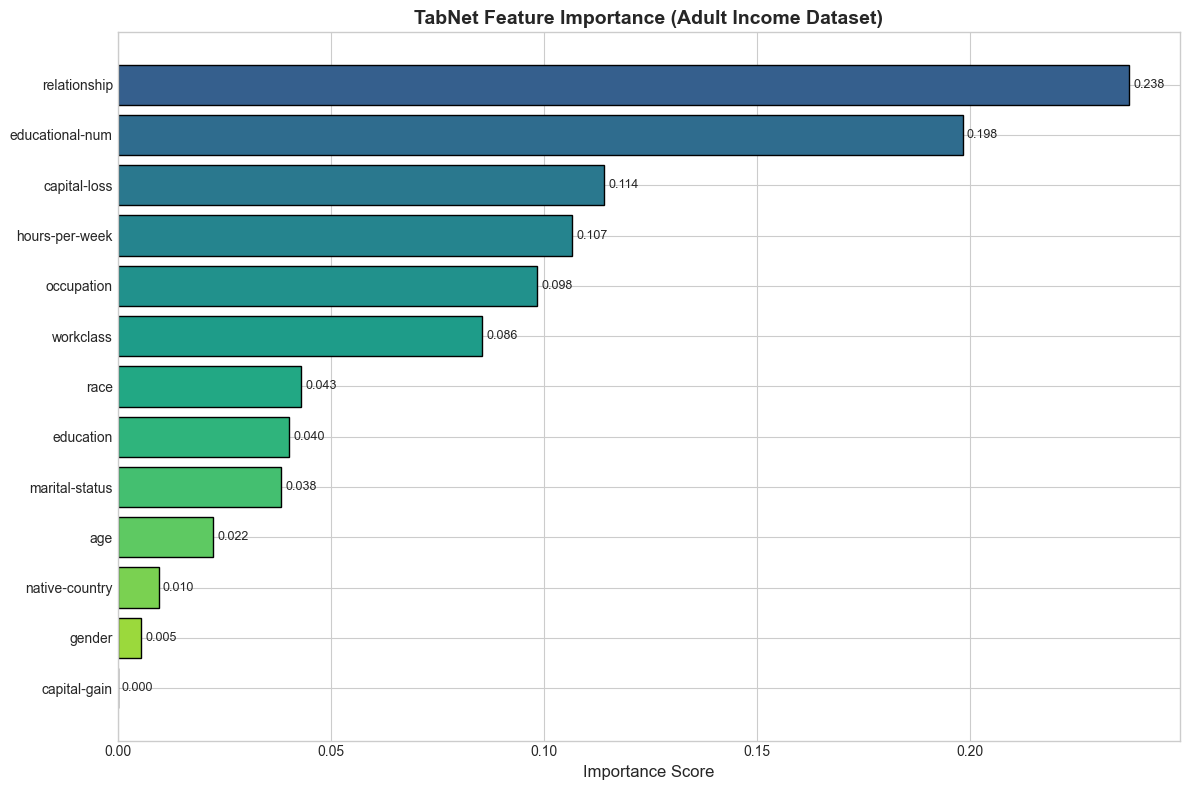


📊 Interpretation:
   TabNet's attention mechanism identifies the most important features for income prediction.
   Top 3 features: relationship, educational-num, capital-loss


In [42]:
# TabNet provides built-in feature importance through attention masks
feature_importances = tabnet_model.feature_importances_

if config.test:
    # For 2D spiral data, show simple bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    
    feature_names = ['X₁ (horizontal)', 'X₂ (vertical)']
    colors = ['#3498DB', '#E74C3C']
    
    bars = ax.bar(feature_names, feature_importances, color=colors, edgecolor='black')
    
    # Add value labels on bars
    for bar, imp in zip(bars, feature_importances):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel('Importance Score')
    ax.set_title('TabNet Feature Importance', fontweight='bold')
    ax.set_ylim(0, max(feature_importances) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Interpretation:")
    print("   Both features are important for spiral classification, as expected.")
    print("   The spiral pattern requires both X and Y coordinates to distinguish classes.")
    
else:
    # For Adult Income dataset, show top features
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get feature names (you'll need to store these during encoding)
    # For now, use generic names or indices
    if 'categorical_cols' in locals() and 'numerical_cols' in locals():
        feature_names = categorical_cols + numerical_cols
    else:
        # Fallback to indices
        feature_names = [f'Feature {i+1}' for i in range(len(feature_importances))]
    
    # Sort by importance
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_importances = feature_importances[sorted_indices]
    sorted_names = [feature_names[i] if i < len(feature_names) else f'F{i}' for i in sorted_indices]
    
    # Plot horizontal bar chart (better for many features)
    colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_importances)))
    bars = ax.barh(range(len(sorted_importances)), sorted_importances, color=colors_grad, edgecolor='black')
    
    ax.set_yticks(range(len(sorted_importances)))
    ax.set_yticklabels(sorted_names)
    ax.set_xlabel('Importance Score')
    ax.set_title('TabNet Feature Importance (Adult Income Dataset)', fontweight='bold', fontsize=14)
    ax.invert_yaxis()  # Highest importance at top
    
    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, sorted_importances)):
        ax.text(imp + 0.001, i, f'{imp:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Interpretation:")
    print("   TabNet's attention mechanism identifies the most important features for income prediction.")
    print(f"   Top 3 features: {', '.join(sorted_names[:3])}")

---

<a id="5-strategies"></a>
## 5. Unlearning Strategy Implementations

We implement five noise-based unlearning strategies, ordered by increasing sophistication:

1. **Gaussian Noise:** Simple isotropic noise injection
2. **Laplacian Noise:** Heavy-tailed noise for sharper disruption
3. **Adaptive Noise:** Magnitude-proportional noise targeting important parameters
4. **Layer-wise Noise:** Progressive noise with layer depth
5. **Gradient-based:** Data-aware gradient ascent with noise refinement

Each strategy returns a copy of the model to preserve the original for comparison.

In [43]:
# =============================================================================
# STRATEGY 1: GAUSSIAN NOISE INJECTION
# =============================================================================

def gaussian_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    noise_scale: float = 0.01,
    seed: int = config.seed
) -> TabNetClassifier:
    """
    Gaussian Noise Injection Unlearning.
    
    This is the simplest noise-based approach, adding Gaussian noise
    N(0, σ²) to all model parameters. The noise scale σ is proportional
    to each parameter's standard deviation, ensuring relative perturbation.
    
    Theoretical basis: Guo et al. (2020) showed that calibrated Gaussian
    noise provides (ε,δ)-certified removal guarantees.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused in this method)
        y_forget: Labels of data to forget (unused in this method)
        noise_scale: Multiplier for noise magnitude (relative to param std)
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    
    Note:
        X_forget and y_forget are included in the signature for API
        consistency with data-aware methods but are not used here.
    """
    # Create deep copy to preserve original model
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for param in unlearned.network.parameters():
            # Calculate parameter's standard deviation
            param_std = torch.std(param)
            
            if param_std > 0:
                # Generate Gaussian noise: N(0, (noise_scale * σ_param)²)
                noise = torch.randn_like(param) * noise_scale * param_std
                
                # Add noise to parameters in-place
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 1: Gaussian Noise Injection defined")

✓ Strategy 1: Gaussian Noise Injection defined


In [44]:
# =============================================================================
# STRATEGY 2: LAPLACIAN NOISE INJECTION
# =============================================================================

def laplacian_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    scale: float = 0.01,
    seed: int = config.seed
) -> TabNetClassifier:
    """
    Laplacian Noise Injection Unlearning.
    
    Uses Laplacian (double exponential) distribution instead of Gaussian.
    The Laplacian has heavier tails, meaning occasional large perturbations
    that can be more effective at disrupting memorized patterns.
    
    Laplacian PDF: f(x) = (1/2b) * exp(-|x|/b)
    
    Theoretical basis: Laplacian noise provides pure ε-differential privacy
    (without the δ term), which can be advantageous for privacy guarantees.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        scale: Scale parameter b for Laplacian distribution
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param).item()
            
            if param_std > 0:
                # Generate Laplacian noise using NumPy (PyTorch lacks native support)
                # Laplacian(0, scale * σ_param)
                noise_np = np.random.laplace(
                    loc=0, 
                    scale=scale * param_std, 
                    size=param.shape
                )
                
                # Convert to PyTorch tensor
                noise = torch.tensor(
                    noise_np, 
                    dtype=param.dtype, 
                    device=param.device
                )
                
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 2: Laplacian Noise Injection defined")

✓ Strategy 2: Laplacian Noise Injection defined


In [45]:
# =============================================================================
# STRATEGY 3: ADAPTIVE (MAGNITUDE-PROPORTIONAL) NOISE
# =============================================================================

def adaptive_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    noise_scale: float = 0.02,
    seed: int = config.seed
) -> TabNetClassifier:
    """
    Adaptive (Magnitude-Proportional) Noise Unlearning.
    
    The noise magnitude for each parameter is proportional to that
    parameter's absolute value. Larger weights (which typically encode
    more significant learned features) receive more noise.
    
    Intuition: Important connections (large weights) are more likely to
    store information about training data, so targeting them should be
    more effective for unlearning.
    
    This approach relates to SalUn (Fan et al., ICLR 2024), which uses
    gradient-based saliency to identify important parameters.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        noise_scale: Base scale for noise generation
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            # Generate base noise
            base_noise = torch.randn_like(param) * noise_scale
            
            # Scale by parameter magnitude: |θ| * noise
            # Larger parameters receive proportionally more noise
            adaptive_noise = base_noise * torch.abs(param)
            
            param.add_(adaptive_noise)
    
    return unlearned


print("✓ Strategy 3: Adaptive Noise Injection defined")

✓ Strategy 3: Adaptive Noise Injection defined


In [46]:
# =============================================================================
# STRATEGY 4: LAYER-WISE PROGRESSIVE NOISE
# =============================================================================

def layerwise_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    base_scale: float = 0.01,
    scale_factor: float = 2.0,
    seed: int = config.seed
) -> TabNetClassifier:
    """
    Layer-wise Progressive Noise Unlearning.
    
    Applies different noise scales to different layers of the network.
    Earlier layers (feature extractors) receive less noise, while later
    layers (decision makers) receive more. This is based on the intuition
    that class-specific information is more concentrated in later layers.
    
    The noise scale progresses linearly from base_scale (first layer) to
    base_scale * scale_factor (last layer).
    
    This approach relates to "Layer Attack Unlearning" (Yoon et al., 2024),
    which found that targeting specific layers can improve unlearning.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        base_scale: Noise scale for the first layer
        scale_factor: Multiplier for final layer (noise increases linearly)
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    # Get all parameters as a list to determine total count
    params = list(unlearned.network.parameters())
    num_params = len(params)
    
    with torch.no_grad():
        for idx, param in enumerate(params):
            # Calculate progress through the network (0.0 to 1.0)
            layer_progress = idx / max(num_params - 1, 1)
            
            # Linear interpolation: base_scale → base_scale * scale_factor
            layer_scale = base_scale * (1 + layer_progress * (scale_factor - 1))
            
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * layer_scale * param_std
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 4: Layer-wise Progressive Noise defined")

✓ Strategy 4: Layer-wise Progressive Noise defined


In [47]:
# =============================================================================
# STRATEGY 5: GRADIENT-BASED UNLEARNING WITH NOISE
# =============================================================================

def gradient_based_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    lr: float = 0.002,
    steps: int = 2,
    noise_scale: float = 0.005,
    seed: int = config.seed
) -> TabNetClassifier:
    """
    Gradient-Based Unlearning with Noise Injection.
    
    This is the most sophisticated approach, combining two techniques:
    
    1. GRADIENT ASCENT: Perform gradient ASCENT (not descent) on the
       forget set. This actively pushes the model to perform WORSE on
       the forget data, effectively "inverting" what was learned.
       
       θ_new = θ + η * ∇L(θ, D_forget)  (note the + sign)
    
    2. NOISE INJECTION: After gradient ascent, add small Gaussian noise
       to prevent the model from simply learning the inverse pattern.
    
    This approach is based on "Descent-to-Delete" (Neel et al., ALT 2021)
    and relates to the "impair-repair" paradigm common in recent work.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (USED for gradient computation)
        y_forget: Labels of data to forget (USED for gradient computation)
        lr: Learning rate for gradient ascent (use smaller than training LR)
        steps: Number of gradient ascent steps (typically 2-5)
        noise_scale: Scale of Gaussian noise added after gradient ascent
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    
    Warning:
        Too many steps or high learning rate can cause catastrophic forgetting
        where the model loses all learned knowledge, not just the forget set.
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    # Convert forget set to PyTorch tensors
    X_tensor = torch.FloatTensor(X_forget)
    y_tensor = torch.LongTensor(y_forget.astype(int))
    
    # Setup for gradient computation
    unlearned.network.train()  # Enable gradient tracking
    optimizer = torch.optim.SGD(unlearned.network.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    # =========================================================================
    # PHASE 1: GRADIENT ASCENT (IMPAIR)
    # =========================================================================
    for step in range(steps):
        optimizer.zero_grad()
        
        # Forward pass through the network
        output, _ = unlearned.network(X_tensor)
        
        # Compute cross-entropy loss
        loss = criterion(output, y_tensor)
        
        # KEY: Negate loss for gradient ASCENT
        # This maximizes loss, making the model worse at the forget set
        (-loss).backward()
        
        optimizer.step()
    
    # =========================================================================
    # PHASE 2: NOISE INJECTION (STABILIZE)
    # =========================================================================
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * noise_scale * param_std
                param.add_(noise)
    
    unlearned.network.eval()  # Return to evaluation mode
    return unlearned


print("✓ Strategy 5: Gradient-Based Unlearning with Noise defined")

✓ Strategy 5: Gradient-Based Unlearning with Noise defined


In [48]:
# =============================================================================
# STRATEGY REGISTRY
# =============================================================================
# Centralized dictionary for easy iteration over all strategies

UNLEARNING_STRATEGIES = {
    'Gaussian': {
        'function': gaussian_noise_unlearning,
        'default_params': {'noise_scale': 0.01},
        'description': 'Isotropic Gaussian noise injection'
    },
    'Laplacian': {
        'function': laplacian_noise_unlearning,
        'default_params': {'scale': 0.01},
        'description': 'Heavy-tailed Laplacian noise injection'
    },
    'Adaptive': {
        'function': adaptive_noise_unlearning,
        'default_params': {'noise_scale': 0.02},
        'description': 'Magnitude-proportional noise injection'
    },
    'Layer-wise': {
        'function': layerwise_noise_unlearning,
        'default_params': {'base_scale': 0.01, 'scale_factor': 2.0},
        'description': 'Progressive noise with layer depth'
    },
    'Gradient-based': {
        'function': gradient_based_noise_unlearning,
        'default_params': {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005},
        'description': 'Gradient ascent with noise refinement'
    }
}

print("="*60)
print("UNLEARNING STRATEGIES SUMMARY")
print("="*60)
for name, info in UNLEARNING_STRATEGIES.items():
    print(f"\n{name}:")
    print(f"  Description: {info['description']}")
    print(f"  Default parameters: {info['default_params']}")

UNLEARNING STRATEGIES SUMMARY

Gaussian:
  Description: Isotropic Gaussian noise injection
  Default parameters: {'noise_scale': 0.01}

Laplacian:
  Description: Heavy-tailed Laplacian noise injection
  Default parameters: {'scale': 0.01}

Adaptive:
  Description: Magnitude-proportional noise injection
  Default parameters: {'noise_scale': 0.02}

Layer-wise:
  Description: Progressive noise with layer depth
  Default parameters: {'base_scale': 0.01, 'scale_factor': 2.0}

Gradient-based:
  Description: Gradient ascent with noise refinement
  Default parameters: {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005}


---

<a id="6-experiments"></a>
## 6. Experimental Design: Forget Requests

### 6.1 The Importance of Removal Strategy

A critical insight in machine unlearning research is that **unlearning difficulty depends not just on the quantity of samples removed, but on their geometric distribution and information content relative to decision boundaries.**

Consider removing 40% of a class:
- **Random removal**: Samples are spread throughout the class region → retained samples still cover the full distribution → model loses little information → unlearning is "easy" (nothing meaningful to forget)
- **Structured removal**: Samples form a contiguous region (e.g., outer edge) → model loses unique boundary information → unlearning is "hard" (real information to erase)

This has profound implications for real-world scenarios:
- Individual GDPR requests (random) may be easier to unlearn
- Demographic group removal (structured) may be significantly harder
- User cohorts (e.g., early adopters, power users) cluster in feature space

### 6.2 Removal Strategies Implemented

We implement six distinct removal strategies to systematically study this effect:

| Strategy | Description | Expected Difficulty |
|----------|-------------|---------------------|
| **Random** | Uniformly random selection | Low (baseline) |
| **Outer Edge** | Samples far from class centroid | High |
| **Inner Core** | Samples near class centroid | High |
| **Angular Wedge** | Contiguous angular section of spiral | High |
| **High Confidence** | Samples model is most confident about | Medium-High |
| **Near Boundary** | Samples close to decision boundary | Very High |

### 6.3 Experimental Design

For a comprehensive analysis, we create forget requests combining:
- **Target class**: Class 1 (representative spiral arm)
- **Removal fraction**: 40% (significant but not complete)
- **Removal strategy**: All 6 strategies above

This allows direct comparison of how removal strategy affects unlearning difficulty.

In [49]:
@dataclass
class ForgetRequest:
    """Container for a forget request and its associated data splits."""
    name: str
    description: str
    strategy: str                 # NEW: Strategy used for selection
    X_retain: np.ndarray          # Features to keep
    y_retain: np.ndarray          # Labels to keep
    X_forget: np.ndarray          # Features to forget
    y_forget: np.ndarray          # Labels to forget
    X_test: np.ndarray            # Test features (original scaling)
    y_test: np.ndarray            # Test labels
    X_retain_baseline: np.ndarray # Retain features rescaled for baseline
    X_test_baseline: np.ndarray   # Test features rescaled for baseline
    forget_indices: np.ndarray    # NEW: Original indices of forgotten samples


# =============================================================================
# REMOVAL STRATEGY FUNCTIONS
# =============================================================================

def select_random(X_class: np.ndarray, n_forget: int, rng: np.random.Generator) -> np.ndarray:
    """
    Random selection - baseline strategy.
    
    Selects samples uniformly at random. This is the typical approach
    but may not represent realistic unlearning scenarios where data
    to be forgotten often has structure.
    
    Args:
        X_class: Features of the target class
        n_forget: Number of samples to select for forgetting
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    indices = rng.choice(len(X_class), n_forget, replace=False)
    mask = np.zeros(len(X_class), dtype=bool)
    mask[indices] = True
    return mask


def select_outer_edge(X_class: np.ndarray, n_forget: int, rng: np.random.Generator) -> np.ndarray:
    """
    Outer edge selection - removes samples far from centroid.
    
    These are samples at the "frontier" of the class distribution.
    Removing them shrinks the learned decision boundary.
    
    Real-world analogy: Removing power users or extreme cases.
    
    Args:
        X_class: Features of the target class
        n_forget: Number of samples to select for forgetting
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    # Compute distance from class centroid
    centroid = X_class.mean(axis=0)
    distances = np.linalg.norm(X_class - centroid, axis=1)
    
    # Select samples with largest distances
    threshold_idx = len(X_class) - n_forget
    threshold = np.partition(distances, threshold_idx)[threshold_idx]
    
    mask = distances >= threshold
    
    # Handle ties: if we have more than n_forget, randomly drop some
    if mask.sum() > n_forget:
        tie_indices = np.where(mask)[0]
        keep = rng.choice(tie_indices, n_forget, replace=False)
        mask = np.zeros(len(X_class), dtype=bool)
        mask[keep] = True
    
    return mask


def select_inner_core(X_class: np.ndarray, n_forget: int, rng: np.random.Generator) -> np.ndarray:
    """
    Inner core selection - removes samples near centroid.
    
    These are the "prototypical" examples of the class.
    Removing them hollows out the center of the distribution.
    
    Real-world analogy: Removing core/founding users.
    
    Args:
        X_class: Features of the target class
        n_forget: Number of samples to select for forgetting
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    # Compute distance from class centroid
    centroid = X_class.mean(axis=0)
    distances = np.linalg.norm(X_class - centroid, axis=1)
    
    # Select samples with smallest distances
    threshold = np.partition(distances, n_forget - 1)[n_forget - 1]
    
    mask = distances <= threshold
    
    # Handle ties
    if mask.sum() > n_forget:
        tie_indices = np.where(mask)[0]
        keep = rng.choice(tie_indices, n_forget, replace=False)
        mask = np.zeros(len(X_class), dtype=bool)
        mask[keep] = True
    
    return mask


def select_angular_wedge(X_class: np.ndarray, n_forget: int, rng: np.random.Generator) -> np.ndarray:
    """
    Angular wedge selection - removes a contiguous angular section.
    
    For spiral data, this removes a "slice" of the spiral,
    creating a gap in the learned representation.
    
    Real-world analogy: Removing all users from a specific time period
    or geographic region that forms a cluster.
    
    Args:
        X_class: Features of the target class
        n_forget: Number of samples to select for forgetting
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    # Compute angle from origin for each point
    angles = np.arctan2(X_class[:, 1], X_class[:, 0])  # Range: [-π, π]
    
    # Determine wedge size needed to capture n_forget samples
    # We'll try multiple starting positions and pick one that gives closest to n_forget
    sorted_angles = np.sort(angles)
    n = len(angles)
    
    best_start = 0
    best_count_diff = float('inf')
    
    # Try different starting angles
    for i in range(0, n, max(1, n // 20)):  # Sample ~20 starting positions
        start_angle = sorted_angles[i]
        # Find how many samples fall in a wedge of the right proportion
        wedge_size = 2 * np.pi * (n_forget / n) * 1.1  # Slightly larger to account for non-uniformity
        end_angle = start_angle + wedge_size
        
        if end_angle > np.pi:
            # Wedge wraps around
            mask = (angles >= start_angle) | (angles <= end_angle - 2*np.pi)
        else:
            mask = (angles >= start_angle) & (angles <= end_angle)
        
        count_diff = abs(mask.sum() - n_forget)
        if count_diff < best_count_diff:
            best_count_diff = count_diff
            best_start = start_angle
    
    # Create final mask with best starting angle
    wedge_size = 2 * np.pi * (n_forget / n)
    end_angle = best_start + wedge_size
    
    if end_angle > np.pi:
        mask = (angles >= best_start) | (angles <= end_angle - 2*np.pi)
    else:
        mask = (angles >= best_start) & (angles <= end_angle)
    
    # Adjust to exactly n_forget if needed
    current_count = mask.sum()
    if current_count > n_forget:
        # Remove some randomly
        forget_indices = np.where(mask)[0]
        keep_indices = rng.choice(forget_indices, n_forget, replace=False)
        mask = np.zeros(len(X_class), dtype=bool)
        mask[keep_indices] = True
    elif current_count < n_forget:
        # Add some from non-selected that are closest to wedge
        needed = n_forget - current_count
        non_selected = np.where(~mask)[0]
        # Add random non-selected samples
        add_indices = rng.choice(non_selected, min(needed, len(non_selected)), replace=False)
        mask[add_indices] = True
    
    return mask


def select_high_confidence(
    X_class: np.ndarray, 
    y_class: np.ndarray,
    n_forget: int, 
    model: TabNetClassifier,
    target_class: int,
    rng: np.random.Generator
) -> np.ndarray:
    """
    High confidence selection - removes samples model is most confident about.
    
    These are the samples that most strongly anchor the class representation.
    Removing them should significantly destabilize the learned boundary.
    
    Real-world analogy: Removing the most active/engaged users whose
    behavior patterns the model has learned most thoroughly.
    
    Args:
        X_class: Features of the target class
        y_class: Labels (all same class, used for verification)
        n_forget: Number of samples to select for forgetting
        model: Trained TabNetClassifier for computing confidence
        target_class: The class being processed
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    # Get prediction probabilities
    probas = model.predict_proba(X_class)
    
    # Confidence = probability assigned to the correct class
    confidence = probas[:, target_class]
    
    # Select samples with highest confidence
    threshold_idx = len(X_class) - n_forget
    threshold = np.partition(confidence, threshold_idx)[threshold_idx]
    
    mask = confidence >= threshold
    
    # Handle ties
    if mask.sum() > n_forget:
        tie_indices = np.where(mask)[0]
        keep = rng.choice(tie_indices, n_forget, replace=False)
        mask = np.zeros(len(X_class), dtype=bool)
        mask[keep] = True
    
    return mask


def select_near_boundary(
    X_class: np.ndarray,
    y_class: np.ndarray, 
    n_forget: int, 
    model: TabNetClassifier,
    target_class: int,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Near boundary selection - removes samples close to decision boundary.
    
    These are the "contested" samples where the model is least certain.
    Removing them could cause the boundary to shift significantly.
    
    Real-world analogy: Removing users with ambiguous behavior patterns
    that don't clearly fit into any category.
    
    Args:
        X_class: Features of the target class
        y_class: Labels (all same class)
        n_forget: Number of samples to select for forgetting
        model: Trained TabNetClassifier
        target_class: The class being processed
        rng: NumPy random generator
    
    Returns:
        Boolean mask where True = forget this sample
    """
    # Get prediction probabilities
    probas = model.predict_proba(X_class)
    
    # Margin = difference between top-1 and top-2 class probabilities
    # Small margin = close to decision boundary
    sorted_probas = np.sort(probas, axis=1)
    margin = sorted_probas[:, -1] - sorted_probas[:, -2]
    
    # Select samples with SMALLEST margin (closest to boundary)
    threshold = np.partition(margin, n_forget - 1)[n_forget - 1]
    
    mask = margin <= threshold
    
    # Handle ties
    if mask.sum() > n_forget:
        tie_indices = np.where(mask)[0]
        keep = rng.choice(tie_indices, n_forget, replace=False)
        mask = np.zeros(len(X_class), dtype=bool)
        mask[keep] = True
    
    return mask


# =============================================================================
# MAIN FORGET REQUEST CREATION
# =============================================================================

def create_forget_requests(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    scaler: StandardScaler,
    model: TabNetClassifier,
    rng: np.random.Generator,
    target_class: int = 1,
    forget_fraction: float = 0.4
) -> Dict[str, ForgetRequest]:
    """
    Create forget requests with different removal strategies.
    
    This function implements the key experimental insight: unlearning
    difficulty depends on HOW samples are selected for removal, not
    just how many.
    
    Args:
        X_train: Original (unscaled) training features
        y_train: Training labels
        X_test: Original (unscaled) test features
        y_test: Test labels
        scaler: Fitted StandardScaler from original training
        model: Trained model (for confidence-based strategies)
        rng: NumPy random generator
        target_class: Which class to remove samples from
        forget_fraction: Fraction of target class to forget
    
    Returns:
        Dictionary mapping forget request names to ForgetRequest objects
    """
    forget_requests = {}
    X_test_scaled = scaler.transform(X_test)
    
    # Get target class samples
    class_mask = y_train == target_class
    class_indices = np.where(class_mask)[0]
    X_class = X_train[class_mask]
    y_class = y_train[class_mask]
    X_class_scaled = scaler.transform(X_class)
    
    n_forget = int(len(class_indices) * forget_fraction)
    
    print(f"Target class: {target_class}")
    print(f"Class samples: {len(class_indices)}")
    print(f"Samples to forget: {n_forget} ({forget_fraction:.0%})")
    print()
    
    # Define all strategies
    strategies = {
        'Random': lambda X, n, r: select_random(X, n, r),
        'Outer Edge': lambda X, n, r: select_outer_edge(X, n, r),
        'Inner Core': lambda X, n, r: select_inner_core(X, n, r),
        'Angular Wedge': lambda X, n, r: select_angular_wedge(X, n, r),
        'High Confidence': lambda X, n, r: select_high_confidence(
            X_class_scaled, y_class, n, model, target_class, r),
        'Near Boundary': lambda X, n, r: select_near_boundary(
            X_class_scaled, y_class, n, model, target_class, r),
    }
    
    for strategy_name, selection_fn in strategies.items():
        # Select samples to forget within the class
        if strategy_name in ['High Confidence', 'Near Boundary']:
            # These need scaled data and model
            within_class_mask = selection_fn(X_class_scaled, n_forget, rng)
        else:
            # Geometric strategies work on unscaled data
            within_class_mask = selection_fn(X_class, n_forget, rng)
        
        # Convert within-class mask to full dataset mask
        forget_mask = np.zeros(len(y_train), dtype=bool)
        forget_mask[class_indices[within_class_mask]] = True
        
        # Create retain/forget splits
        X_retain = X_train[~forget_mask]
        y_retain = y_train[~forget_mask]
        X_forget = X_train[forget_mask]
        y_forget = y_train[forget_mask]
        
        # Scale data
        X_retain_scaled = scaler.transform(X_retain)
        # Handle empty X_forget case (when target_class has no samples)
        if len(X_forget) == 0:
            # Create empty array with correct shape (0, n_features)
            n_features = X_retain.shape[1] if len(X_retain) > 0 else X_test.shape[1]
            X_forget_scaled = np.empty((0, n_features))
        else:
            X_forget_scaled = scaler.transform(X_forget)
        
        # Rescale for baseline retraining
        scaler_baseline = StandardScaler()
        X_retain_baseline = scaler_baseline.fit_transform(X_retain)
        X_test_baseline = scaler_baseline.transform(X_test)
        
        # Create ForgetRequest
        fr_name = f"FR-{strategy_name}"
        forget_requests[fr_name] = ForgetRequest(
            name=fr_name,
            description=f"Remove {forget_fraction:.0%} of Class {target_class} using {strategy_name} strategy",
            strategy=strategy_name,
            X_retain=X_retain_scaled,
            y_retain=y_retain,
            X_forget=X_forget_scaled,
            y_forget=y_forget,
            X_test=X_test_scaled,
            y_test=y_test,
            X_retain_baseline=X_retain_baseline,
            X_test_baseline=X_test_baseline,
            forget_indices=np.where(forget_mask)[0]
        )
        
        print(f"✓ {strategy_name:20s}: {forget_mask.sum()} samples selected")
    
    return forget_requests


# =============================================================================
# ALSO ADD FR0: Complete class removal for comparison
# =============================================================================

def create_complete_class_removal_request(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    scaler: StandardScaler,
    target_class: int = 2
) -> ForgetRequest:
    """Create a forget request for complete class removal."""
    
    class_mask = y_train == target_class
    
    X_retain = X_train[~class_mask]
    y_retain = y_train[~class_mask]
    X_forget = X_train[class_mask]
    y_forget = y_train[class_mask]
    
    X_retain_scaled = scaler.transform(X_retain)
    # Handle empty X_forget case (when target_class has no samples)
    if len(X_forget) == 0:
        # Create empty array with correct shape (0, n_features)
        n_features = X_retain.shape[1] if len(X_retain) > 0 else X_test.shape[1]
        X_forget_scaled = np.empty((0, n_features))
    else:
        X_forget_scaled = scaler.transform(X_forget)
    X_test_scaled = scaler.transform(X_test)
    
    scaler_baseline = StandardScaler()
    X_retain_baseline = scaler_baseline.fit_transform(X_retain)
    X_test_baseline = scaler_baseline.transform(X_test)
    
    return ForgetRequest(
        name="FR0-Complete",
        description=f"Complete removal of Class {target_class}",
        strategy="Complete Class",
        X_retain=X_retain_scaled,
        y_retain=y_retain,
        X_forget=X_forget_scaled,
        y_forget=y_forget,
        X_test=X_test_scaled,
        y_test=y_test,
        X_retain_baseline=X_retain_baseline,
        X_test_baseline=X_test_baseline,
        forget_indices=np.where(class_mask)[0]
    )


# Create all forget requests
print("=" * 60)
print("CREATING FORGET REQUESTS")
print("=" * 60)
print()

# First, add the complete class removal as baseline
print("Creating complete class removal request (FR0)...")
fr_complete = create_complete_class_removal_request(
    X_train, y_train, X_test, y_test, scaler, target_class=2
)
print(f"✓ Complete Class: {len(fr_complete.y_forget)} samples (all of Class 2)")
print()

# Then create strategic removal requests
print("Creating strategic removal requests for Class 1...")
forget_requests = create_forget_requests(
    X_train, y_train, X_test, y_test, scaler, tabnet_model, rng,
    target_class=1, forget_fraction=0.4
)

# Add complete class removal to the dict
forget_requests['FR0: Complete Class'] = fr_complete

print()
print("=" * 60)
print("FORGET REQUESTS SUMMARY")
print("=" * 60)
for name, fr in forget_requests.items():
    print(f"\n{name}:")
    print(f"  Strategy: {fr.strategy}")
    print(f"  Description: {fr.description}")
    print(f"  Retain samples: {len(fr.y_retain):,}")
    print(f"  Forget samples: {len(fr.y_forget):,}")
    print(f"  Forget ratio: {len(fr.y_forget) / (len(fr.y_retain) + len(fr.y_forget)):.1%}")

CREATING FORGET REQUESTS

Creating complete class removal request (FR0)...
✓ Complete Class: 0 samples (all of Class 2)

Creating strategic removal requests for Class 1...
Target class: 1
Class samples: 9349
Samples to forget: 3739 (40%)

✓ Random              : 3739 samples selected
✓ Outer Edge          : 3739 samples selected
✓ Inner Core          : 3739 samples selected
✓ Angular Wedge       : 3739 samples selected
✓ High Confidence     : 3739 samples selected
✓ Near Boundary       : 3739 samples selected

FORGET REQUESTS SUMMARY

FR-Random:
  Strategy: Random
  Description: Remove 40% of Class 1 using Random strategy
  Retain samples: 35,334
  Forget samples: 3,739
  Forget ratio: 9.6%

FR-Outer Edge:
  Strategy: Outer Edge
  Description: Remove 40% of Class 1 using Outer Edge strategy
  Retain samples: 35,334
  Forget samples: 3,739
  Forget ratio: 9.6%

FR-Inner Core:
  Strategy: Inner Core
  Description: Remove 40% of Class 1 using Inner Core strategy
  Retain samples: 35,334
 

### 6.4 Visualize Removal Strategies

Let's visualize how each strategy selects samples for removal.


VISUALIZING REMOVAL STRATEGIES


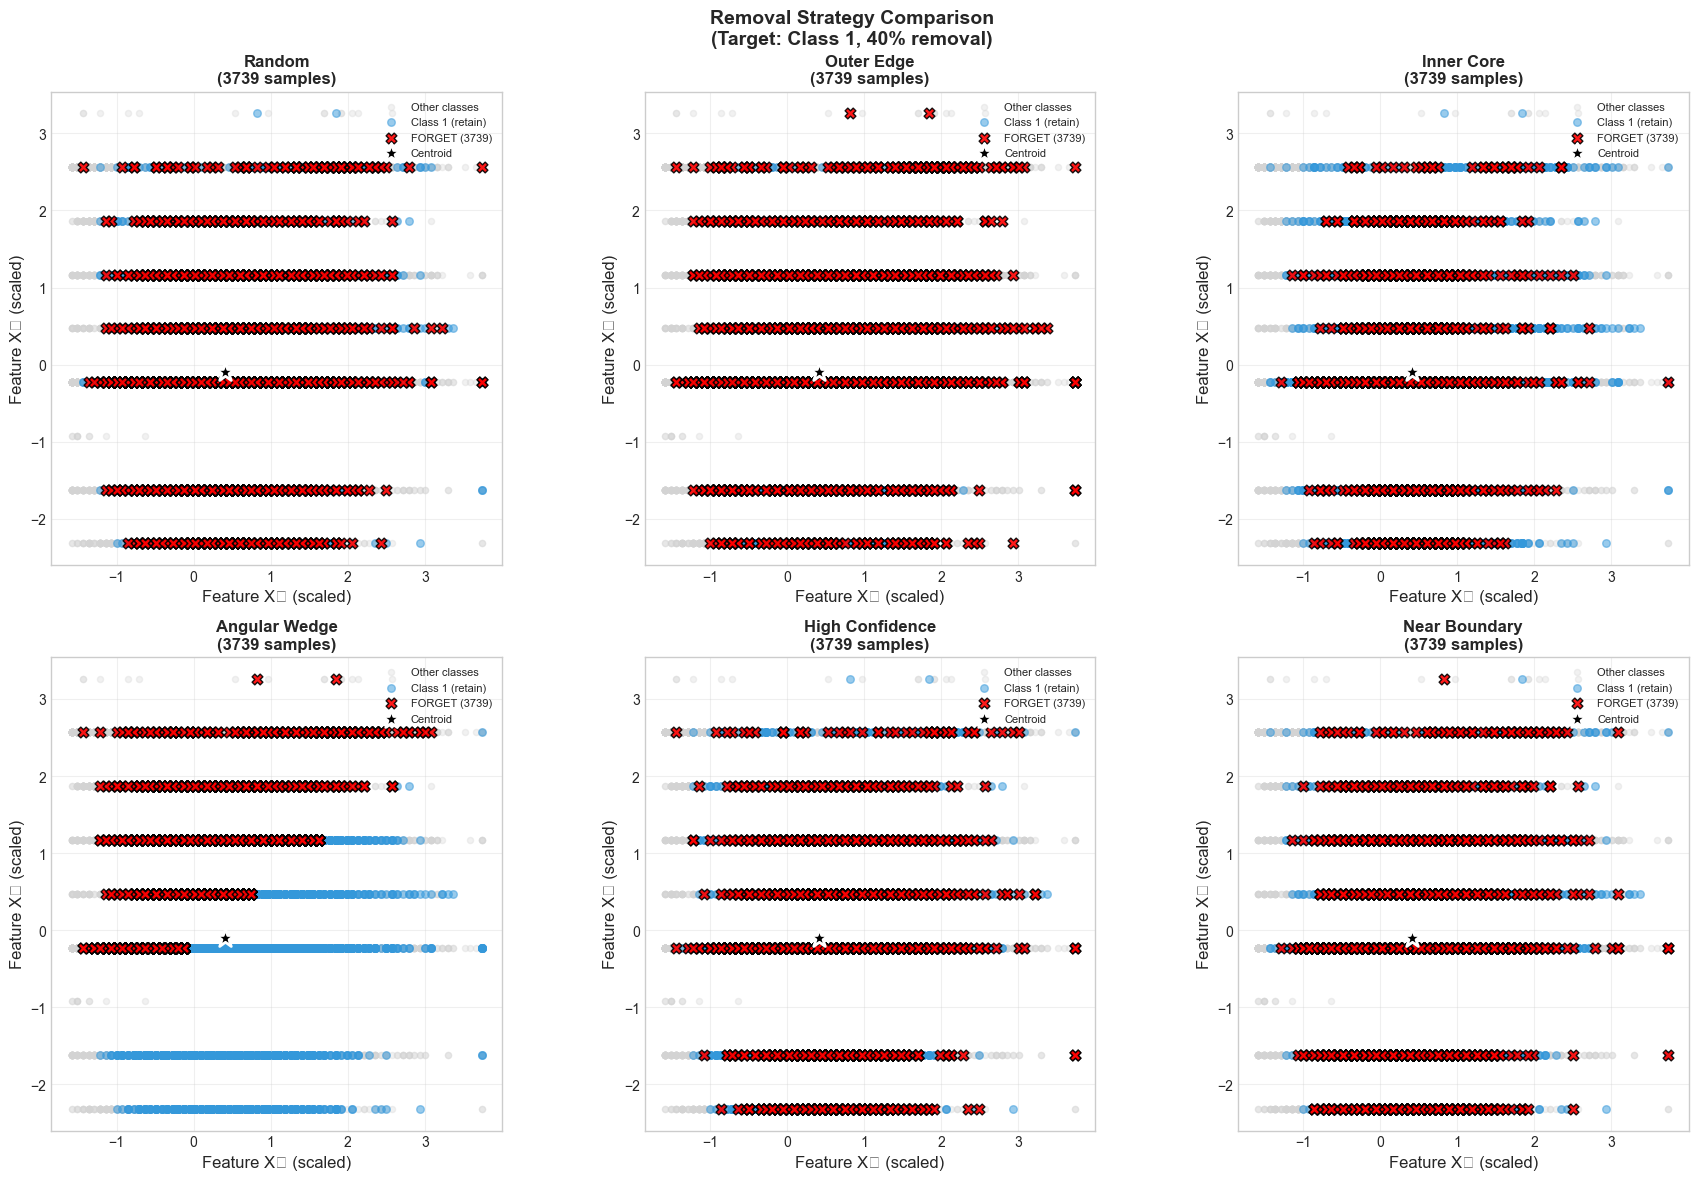


INTERPRETATION GUIDE

    • RANDOM: Samples spread throughout - minimal information loss
    • OUTER EDGE: Boundary samples removed - shrinks class region  
    • INNER CORE: Central samples removed - hollows out class
    • ANGULAR WEDGE: Contiguous section - creates gap in spiral
    • HIGH CONFIDENCE: Best-learned samples - destabilizes anchors
    • NEAR BOUNDARY: Contested samples - shifts decision boundary

    Hypothesis: Structured removal (non-random) should be HARDER to
    unlearn because it removes unique, non-redundant information.
    


In [50]:
def visualize_removal_strategies(
    X_train: np.ndarray,
    y_train: np.ndarray,
    forget_requests: Dict[str, ForgetRequest],
    scaler: StandardScaler,
    target_class: int = 1
) -> None:
    """
    Visualize how different removal strategies select samples.
    
    This is crucial for understanding why unlearning difficulty varies.
    
    Args:
        X_train: Original training features
        y_train: Training labels
        forget_requests: Dictionary of forget requests
        scaler: Fitted StandardScaler
        target_class: The class being analyzed
    """
    # Filter to only strategic removal requests (not complete class)
    strategic_requests = {k: v for k, v in forget_requests.items() 
                         if v.strategy != "Complete Class"}
    
    n_strategies = len(strategic_requests)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get class data for visualization
    X_scaled = scaler.transform(X_train)
    class_mask = y_train == target_class
    
    for idx, (name, fr) in enumerate(strategic_requests.items()):
        ax = axes[idx]
        
        # Determine which samples from target class are forgotten
        forget_mask_full = np.zeros(len(y_train), dtype=bool)
        forget_mask_full[fr.forget_indices] = True
        
        # Plot all other classes (light gray)
        other_mask = y_train != target_class
        ax.scatter(X_scaled[other_mask, 0], X_scaled[other_mask, 1],
                  c='lightgray', alpha=0.3, s=20, label='Other classes')
        
        # Plot retained samples of target class
        retain_mask = class_mask & ~forget_mask_full
        ax.scatter(X_scaled[retain_mask, 0], X_scaled[retain_mask, 1],
                  c=CLASS_COLORS[target_class], alpha=0.5, s=30, 
                  label=f'Class {target_class} (retain)')
        
        # Plot forgotten samples of target class (highlighted)
        ax.scatter(X_scaled[forget_mask_full, 0], X_scaled[forget_mask_full, 1],
                  c='red', alpha=0.9, s=60, edgecolors='black', linewidths=1,
                  marker='X', label=f'FORGET ({len(fr.y_forget)})')
        
        # Add centroid marker
        centroid = X_scaled[class_mask].mean(axis=0)
        ax.scatter(centroid[0], centroid[1], c='black', s=200, marker='*',
                  edgecolors='white', linewidths=2, zorder=100, label='Centroid')
        
        ax.set_title(f"{fr.strategy}\n({len(fr.y_forget)} samples)", 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('Feature X₁ (scaled)')
        ax.set_ylabel('Feature X₂ (scaled)')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplot
    if n_strategies < 6:
        for idx in range(n_strategies, 6):
            axes[idx].set_visible(False)
    
    plt.suptitle(f"Removal Strategy Comparison\n(Target: Class {target_class}, 40% removal)",
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)
    print("INTERPRETATION GUIDE")
    print("=" * 60)
    print("""
    • RANDOM: Samples spread throughout - minimal information loss
    • OUTER EDGE: Boundary samples removed - shrinks class region  
    • INNER CORE: Central samples removed - hollows out class
    • ANGULAR WEDGE: Contiguous section - creates gap in spiral
    • HIGH CONFIDENCE: Best-learned samples - destabilizes anchors
    • NEAR BOUNDARY: Contested samples - shifts decision boundary
    
    Hypothesis: Structured removal (non-random) should be HARDER to
    unlearn because it removes unique, non-redundant information.
    """)


# Visualize the removal strategies
print("\n" + "=" * 60)
print("VISUALIZING REMOVAL STRATEGIES")
print("=" * 60)

visualize_removal_strategies(X_train, y_train, forget_requests, scaler, target_class=1)

---

<a id="7-evaluation"></a>
## 7. Comprehensive Evaluation

### 7.1 Evaluation Metrics

We evaluate unlearning quality using multiple complementary metrics:

In [51]:
@dataclass
class UnlearningMetrics:
    """Container for all unlearning evaluation metrics."""
    retain_accuracy: float      # Accuracy on retain set (higher = better)
    forget_accuracy: float      # Accuracy on forget set (lower = better)
    test_accuracy: float        # Accuracy on test set (higher = better)
    mia_auc: float             # MIA attack AUC (closer to 0.5 = better)
    param_distance: float       # L2 distance from original model
    balance_score: float        # Combined metric: retain + test - forget
    unlearning_time: float      # Time taken for unlearning (seconds)


def compute_mia_vulnerability(
    model: TabNetClassifier,
    X_members: np.ndarray,
    X_non_members: np.ndarray
) -> float:
    """
    Compute Membership Inference Attack (MIA) vulnerability.
    
    MIA tests whether an adversary can determine if a sample was in
    the training set based on the model's prediction confidence.
    
    We use a simple threshold-based attack:
    - Compute max prediction probability for each sample
    - Members (training data) typically have higher confidence
    - Non-members have lower confidence
    
    The AUC measures how well these can be distinguished:
    - AUC = 0.5: Random guessing (no information leakage) ✓
    - AUC = 1.0: Perfect attack (complete information leakage) ✗
    
    For successful unlearning, forget set AUC should approach 0.5.
    
    Args:
        model: Trained TabNetClassifier
        X_members: Features of samples that WERE in training
        X_non_members: Features of samples that were NOT in training
    
    Returns:
        AUC score for the membership inference attack
    """
    # Get prediction probabilities
    proba_members = model.predict_proba(X_members)
    proba_non_members = model.predict_proba(X_non_members)
    
    # Use max probability as membership signal
    confidence_members = np.max(proba_members, axis=1)
    confidence_non_members = np.max(proba_non_members, axis=1)
    
    # Combine into attack dataset
    confidences = np.concatenate([confidence_members, confidence_non_members])
    labels = np.concatenate([
        np.ones(len(confidence_members)),   # 1 = member
        np.zeros(len(confidence_non_members))  # 0 = non-member
    ])
    
    # Compute AUC (handle edge cases)
    try:
        auc = roc_auc_score(labels, confidences)
    except ValueError:
        auc = 0.5  # Default to random if computation fails
    
    return auc


def compute_parameter_distance(
    model1: TabNetClassifier,
    model2: TabNetClassifier
) -> float:
    """
    Compute L2 distance between two models' parameters.
    
    This measures how much the unlearning process changed the model.
    Smaller distance from a retrained model indicates better unlearning.
    
    Args:
        model1: First TabNetClassifier
        model2: Second TabNetClassifier
    
    Returns:
        L2 norm of parameter difference
    """
    total_distance = 0.0
    
    params1 = list(model1.network.parameters())
    params2 = list(model2.network.parameters())
    
    for p1, p2 in zip(params1, params2):
        diff = (p1 - p2).detach().cpu().numpy()
        total_distance += np.sum(diff ** 2)
    
    return np.sqrt(total_distance)


def evaluate_unlearning(
    model: TabNetClassifier,
    original_model: TabNetClassifier,
    fr: ForgetRequest,
    unlearning_time: float = 0.0
) -> UnlearningMetrics:
    """
    Compute all evaluation metrics for an unlearned model.
    
    Args:
        model: Unlearned TabNetClassifier
        original_model: Original trained model (for parameter distance)
        fr: ForgetRequest with data splits
        unlearning_time: Time taken for unlearning
    
    Returns:
        UnlearningMetrics dataclass with all computed metrics
    """
    # Accuracy metrics
    retain_acc = accuracy_score(fr.y_retain, model.predict(fr.X_retain))
    forget_acc = accuracy_score(fr.y_forget, model.predict(fr.X_forget))
    test_acc = accuracy_score(fr.y_test, model.predict(fr.X_test))
    
    # MIA vulnerability (using test set as non-members)
    mia_auc = compute_mia_vulnerability(model, fr.X_forget, fr.X_test)
    
    # Parameter distance from original
    param_dist = compute_parameter_distance(model, original_model)
    
    # Balance score: higher is better
    balance = retain_acc + test_acc - forget_acc
    
    return UnlearningMetrics(
        retain_accuracy=retain_acc,
        forget_accuracy=forget_acc,
        test_accuracy=test_acc,
        mia_auc=mia_auc,
        param_distance=param_dist,
        balance_score=balance,
        unlearning_time=unlearning_time
    )


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 7.2 Baseline Retraining (Gold Standard)

The gold standard for unlearning is retraining from scratch on only the retain set. This provides the target behavior that approximate unlearning methods aim to match.

In [ ]:
def train_baseline_model(
    fr: ForgetRequest,
    config: ExperimentConfig
) -> Tuple[TabNetClassifier, float]:
    """
    Train a baseline model from scratch on only the retain set.
    
    This is the "gold standard" for unlearning: a model that never
    saw the forget data in the first place.
    
    Args:
        fr: ForgetRequest with data splits
        config: Experiment configuration
    
    Returns:
        Tuple of (trained model, training time)
    """
    start_time = time.time()
    
    model = create_tabnet_model(config, verbose=0)
    model.fit(
        fr.X_retain_baseline, 
        fr.y_retain.astype(int),
        max_epochs=config.max_epochs,
        patience=config.patience,
        batch_size=config.batch_size,
        virtual_batch_size=config.virtual_batch_size
    )
    
    training_time = time.time() - start_time
    return model, training_time


# Train baseline models for each forget request
print("="*60)
print("TRAINING BASELINE MODELS (GOLD STANDARD)")
print("="*60)
print("\nThis simulates 'perfect' unlearning by retraining from scratch.\n")

baseline_models = {}
baseline_metrics_dict = {}

for name, fr in tqdm(forget_requests.items(), desc="Training baselines"):
    model, train_time = train_baseline_model(fr, config)
    baseline_models[name] = model
    
    # Evaluate on rescaled data (for fair comparison)
    # Note: Baseline uses its own scaler, so we need to be careful
    retain_acc = accuracy_score(
        fr.y_retain, 
        model.predict(fr.X_retain_baseline)
    )
    test_acc = accuracy_score(
        fr.y_test, 
        model.predict(fr.X_test_baseline)
    )
    # For forget accuracy, we need to rescale forget set with baseline scaler
    # But we don't have access to it, so we skip for now and use test as proxy
    
    baseline_metrics_dict[name] = {
        'retain': retain_acc,
        'test': test_acc,
        'time': train_time
    }
    
    print(f"\n{name}:")
    print(f"  Retain accuracy: {retain_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")
    print(f"  Training time: {train_time:.2f}s")

TRAINING BASELINE MODELS (GOLD STANDARD)

This simulates 'perfect' unlearning by retraining from scratch.



Training baselines:  14%|█▍        | 1/7 [23:22<2:20:17, 1402.84s/it]


FR-Random:
  Retain accuracy: 0.8854
  Test accuracy: 0.8393
  Training time: 1400.17s


### 7.3 Run All Unlearning Experiments

In [ ]:
def run_unlearning_experiment(
    original_model: TabNetClassifier,
    strategy_name: str,
    strategy_info: dict,
    fr: ForgetRequest,
    seed: int = config.seed
) -> Tuple[TabNetClassifier, UnlearningMetrics]:
    """
    Run a single unlearning experiment.
    
    Args:
        original_model: The trained model to unlearn from
        strategy_name: Name of the strategy
        strategy_info: Dictionary with function and default params
        fr: ForgetRequest with data splits
        seed: Random seed
    
    Returns:
        Tuple of (unlearned model, metrics)
    """
    unlearn_fn = strategy_info['function']
    params = strategy_info['default_params'].copy()
    params['seed'] = seed
    
    # Time the unlearning process
    start_time = time.time()
    unlearned_model = unlearn_fn(
        original_model, 
        fr.X_forget, 
        fr.y_forget,
        **params
    )
    unlearning_time = time.time() - start_time
    
    # Evaluate
    metrics = evaluate_unlearning(
        unlearned_model, 
        original_model, 
        fr,
        unlearning_time
    )
    
    return unlearned_model, metrics


# Run all experiments
print("="*60)
print("RUNNING UNLEARNING EXPERIMENTS")
print("="*60)
print(f"\nTotal experiments: {len(forget_requests)} × {len(UNLEARNING_STRATEGIES)} = "
      f"{len(forget_requests) * len(UNLEARNING_STRATEGIES)}\n")

all_results = {}  # {forget_request: {strategy: metrics}}
all_models = {}   # {forget_request: {strategy: model}}

for fr_name, fr in forget_requests.items():
    print(f"\n{'='*60}")
    print(f"Processing: {fr_name}")
    print(f"{'='*60}")
    
    all_results[fr_name] = {}
    all_models[fr_name] = {}
    
    for strategy_name, strategy_info in UNLEARNING_STRATEGIES.items():
        model, metrics = run_unlearning_experiment(
            tabnet_model,
            strategy_name,
            strategy_info,
            fr,
            config.seed
        )
        
        all_results[fr_name][strategy_name] = metrics
        all_models[fr_name][strategy_name] = model
        
        # Print summary
        status = "✓" if metrics.forget_accuracy < 0.4 else "✗"
        print(f"  {strategy_name:15s} | Retain: {metrics.retain_accuracy:.3f} | "
              f"Forget: {metrics.forget_accuracy:.3f} | "
              f"Test: {metrics.test_accuracy:.3f} | "
              f"MIA: {metrics.mia_auc:.3f} | {status}")

print(f"\n{'='*60}")
print("✓ All experiments completed!")
print(f"{'='*60}")

RUNNING UNLEARNING EXPERIMENTS

Total experiments: 7 × 5 = 35


Processing: FR-Random
  Gaussian        | Retain: 0.964 | Forget: 0.917 | Test: 0.946 | MIA: 0.521 | ✗
  Laplacian       | Retain: 0.966 | Forget: 0.917 | Test: 0.950 | MIA: 0.514 | ✗
  Adaptive        | Retain: 0.969 | Forget: 0.927 | Test: 0.950 | MIA: 0.511 | ✗
  Layer-wise      | Retain: 0.964 | Forget: 0.917 | Test: 0.946 | MIA: 0.515 | ✗
  Gradient-based  | Retain: 0.962 | Forget: 0.906 | Test: 0.938 | MIA: 0.510 | ✗

Processing: FR-Outer Edge
  Gaussian        | Retain: 0.970 | Forget: 0.865 | Test: 0.946 | MIA: 0.343 | ✗
  Laplacian       | Retain: 0.971 | Forget: 0.875 | Test: 0.950 | MIA: 0.337 | ✗
  Adaptive        | Retain: 0.971 | Forget: 0.906 | Test: 0.950 | MIA: 0.353 | ✗
  Layer-wise      | Retain: 0.970 | Forget: 0.865 | Test: 0.946 | MIA: 0.339 | ✗
  Gradient-based  | Retain: 0.969 | Forget: 0.844 | Test: 0.921 | MIA: 0.318 | ✗

Processing: FR-Inner Core
  Gaussian        | Retain: 0.961 | Forget: 0.948 

---

<a id="8-optimization"></a>
## 8. Hyperparameter Optimization

We perform a grid search to find optimal hyperparameters for each strategy.

In [ ]:
# Define parameter grids for each strategy
PARAM_GRIDS = {
    'Gaussian': {
        'noise_scale': [0.005, 0.01, 0.02, 0.05, 0.1]
    },
    'Laplacian': {
        'scale': [0.005, 0.01, 0.02, 0.05, 0.1]
    },
    'Adaptive': {
        'noise_scale': [0.01, 0.02, 0.05, 0.1, 0.2]
    },
    'Layer-wise': {
        'base_scale': [0.005, 0.01, 0.02],
        'scale_factor': [1.5, 2.0, 3.0]
    },
    'Gradient-based': {
        'lr': [0.001, 0.002, 0.005],
        'steps': [1, 2, 3, 5],
        'noise_scale': [0.001, 0.005, 0.01]
    }
}


def grid_search_strategy(
    original_model: TabNetClassifier,
    strategy_name: str,
    param_grid: dict,
    fr: ForgetRequest,
    seed: int = config.seed
) -> Tuple[dict, UnlearningMetrics]:
    """
    Perform grid search for optimal hyperparameters.
    
    Uses balance_score (retain + test - forget) as the optimization target.
    
    Args:
        original_model: Trained model to unlearn from
        strategy_name: Name of the strategy
        param_grid: Dictionary of parameter names to value lists
        fr: ForgetRequest with data splits
        seed: Random seed
    
    Returns:
        Tuple of (best_params, best_metrics)
    """
    import itertools
    
    unlearn_fn = UNLEARNING_STRATEGIES[strategy_name]['function']
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    best_score = -float('inf')
    best_params = None
    best_metrics = None
    
    for combo in itertools.product(*param_values):
        params = dict(zip(param_names, combo))
        params['seed'] = seed
        
        # Run unlearning
        start_time = time.time()
        unlearned = unlearn_fn(original_model, fr.X_forget, fr.y_forget, **params)
        unlearn_time = time.time() - start_time
        
        # Evaluate
        metrics = evaluate_unlearning(unlearned, original_model, fr, unlearn_time)
        
        # Check if best
        if metrics.balance_score > best_score:
            best_score = metrics.balance_score
            best_params = {k: v for k, v in params.items() if k != 'seed'}
            best_metrics = metrics
    
    return best_params, best_metrics


# Run hyperparameter optimization (only on FR1 for time efficiency)
print("="*60)
print("HYPERPARAMETER OPTIMIZATION")
print("="*60)
print("\nOptimizing on FR0: Complete Class (primary use case)\n")

fr_optimize = forget_requests['FR0: Complete Class']
best_configs = {}

for strategy_name, param_grid in tqdm(PARAM_GRIDS.items(), desc="Optimizing"):
    best_params, best_metrics = grid_search_strategy(
        tabnet_model,
        strategy_name,
        param_grid,
        fr_optimize,
        config.seed
    )
    
    best_configs[strategy_name] = {
        'params': best_params,
        'metrics': best_metrics
    }
    
    print(f"\n{strategy_name}:")
    print(f"  Best params: {best_params}")
    print(f"  Balance score: {best_metrics.balance_score:.4f}")
    print(f"  Retain: {best_metrics.retain_accuracy:.3f} | "
          f"Forget: {best_metrics.forget_accuracy:.3f} | "
          f"Test: {best_metrics.test_accuracy:.3f}")

HYPERPARAMETER OPTIMIZATION

Optimizing on FR0: Complete Class (primary use case)



Optimizing:  20%|██        | 1/5 [00:00<00:00,  9.99it/s]


Gaussian:
  Best params: {'noise_scale': 0.005}
  Balance score: 0.9514
  Retain: 0.964 | Forget: 0.958 | Test: 0.946

Laplacian:
  Best params: {'scale': 0.05}
  Balance score: 0.9681
  Retain: 0.922 | Forget: 0.821 | Test: 0.867


Optimizing:  60%|██████    | 3/5 [00:00<00:00, 10.20it/s]


Adaptive:
  Best params: {'noise_scale': 0.01}
  Balance score: 0.9542
  Retain: 0.967 | Forget: 0.963 | Test: 0.950

Layer-wise:
  Best params: {'base_scale': 0.01, 'scale_factor': 2.0}
  Balance score: 0.9528
  Retain: 0.961 | Forget: 0.954 | Test: 0.946


Optimizing: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Gradient-based:
  Best params: {'lr': 0.005, 'steps': 5, 'noise_scale': 0.001}
  Balance score: 1.0028
  Retain: 0.932 | Forget: 0.787 | Test: 0.858


---

<a id="9-results"></a>
## 9. Results Analysis & Visualization

### 9.1 Results Summary Table

In [ ]:
def create_results_dataframe(all_results: dict) -> pd.DataFrame:
    """
    Create a pandas DataFrame from the results dictionary.
    
    Args:
        all_results: Nested dictionary of results
    
    Returns:
        DataFrame with all metrics
    """
    rows = []
    
    for fr_name, strategies in all_results.items():
        for strategy_name, metrics in strategies.items():
            rows.append({
                'Forget Request': fr_name,
                'Strategy': strategy_name,
                'Retain Acc': metrics.retain_accuracy,
                'Forget Acc': metrics.forget_accuracy,
                'Test Acc': metrics.test_accuracy,
                'MIA AUC': metrics.mia_auc,
                'Param Distance': metrics.param_distance,
                'Balance Score': metrics.balance_score,
                'Time (s)': metrics.unlearning_time
            })
    
    return pd.DataFrame(rows)


# Create and display results table
results_df = create_results_dataframe(all_results)

print("="*100)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*100)

# Format for display
display_df = results_df.copy()
display_df['Retain Acc'] = display_df['Retain Acc'].map('{:.3f}'.format)
display_df['Forget Acc'] = display_df['Forget Acc'].map('{:.3f}'.format)
display_df['Test Acc'] = display_df['Test Acc'].map('{:.3f}'.format)
display_df['MIA AUC'] = display_df['MIA AUC'].map('{:.3f}'.format)
display_df['Balance Score'] = display_df['Balance Score'].map('{:.3f}'.format)
display_df['Time (s)'] = display_df['Time (s)'].map('{:.4f}'.format)

print(display_df.to_string(index=False))

COMPREHENSIVE RESULTS SUMMARY
     Forget Request       Strategy Retain Acc Forget Acc Test Acc MIA AUC  Param Distance Balance Score Time (s)
          FR-Random       Gaussian      0.964      0.917    0.946   0.521        0.520105         0.993   0.0090
          FR-Random      Laplacian      0.966      0.917    0.950   0.514        0.740851         1.000   0.0115
          FR-Random       Adaptive      0.969      0.927    0.950   0.511        1.177961         0.992   0.0068
          FR-Random     Layer-wise      0.964      0.917    0.946   0.515        0.759455         0.993   0.0059
          FR-Random Gradient-based      0.962      0.906    0.938   0.510        0.261201         0.993   0.0130
      FR-Outer Edge       Gaussian      0.970      0.865    0.946   0.343        0.520105         1.051   0.0058
      FR-Outer Edge      Laplacian      0.971      0.875    0.950   0.337        0.740851         1.046   0.0059
      FR-Outer Edge       Adaptive      0.971      0.906    0.950 

### 9.2 Heatmap Visualization

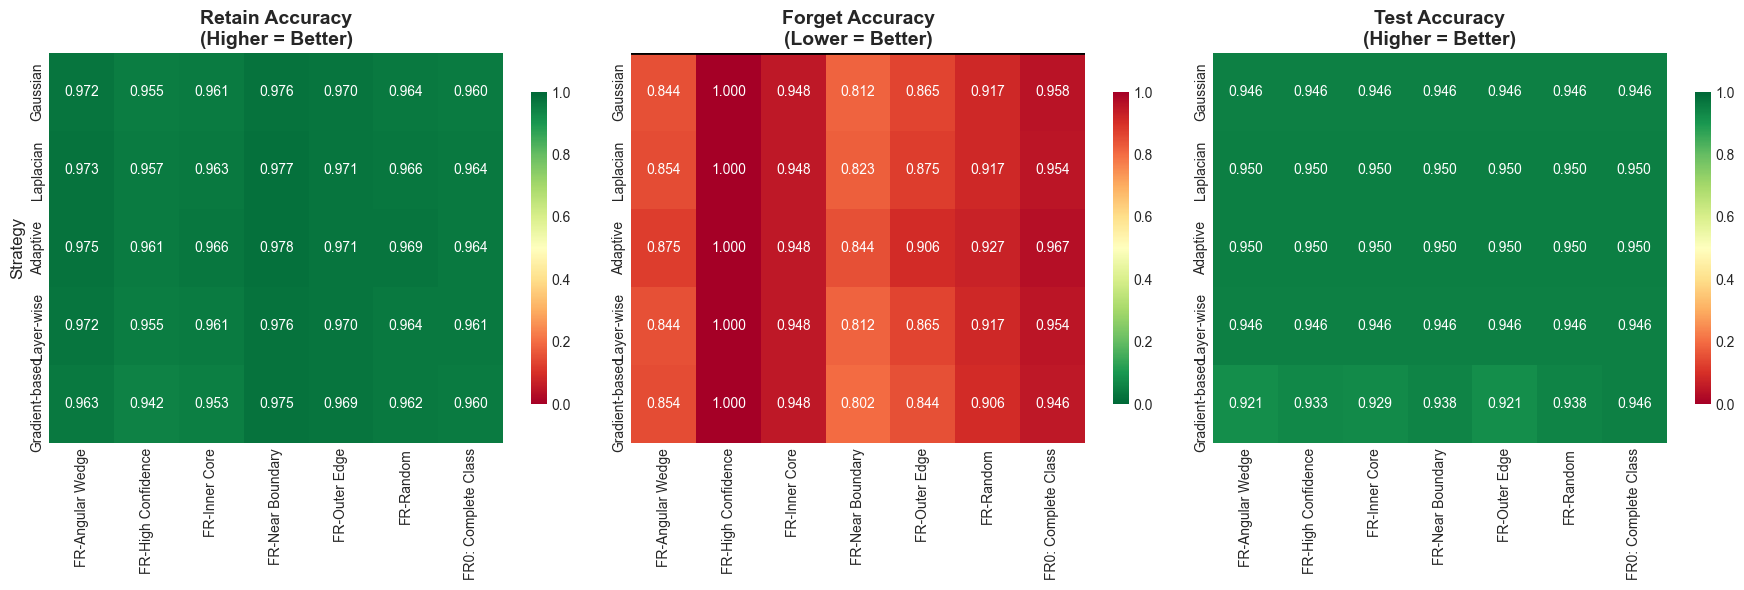


📊 Interpretation Guide:
  • Target Forget Accuracy: 25% (random guessing)
  • Target Retain Accuracy: >90%
  • Target MIA AUC: ~50% (no information leakage)


In [ ]:
def plot_metrics_heatmaps(results_df: pd.DataFrame) -> None:
    """
    Create heatmap visualizations for all metrics.
    
    Args:
        results_df: DataFrame with results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    strategies = results_df['Strategy'].unique()
    forget_requests = results_df['Forget Request'].unique()
    
    # Pivot tables for each metric
    retain_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Retain Acc'
    ).reindex(strategies)
    
    forget_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Forget Acc'
    ).reindex(strategies)
    
    test_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Test Acc'
    ).reindex(strategies)
    
    # Plot 1: Retain Accuracy (higher = better = green)
    sns.heatmap(
        retain_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
        vmin=0.0, vmax=1.0, ax=axes[0], cbar_kws={'shrink': 0.8}
    )
    axes[0].set_title('Retain Accuracy\n(Higher = Better)', fontweight='bold')
    axes[0].set_ylabel('Strategy')
    axes[0].set_xlabel('')
    
    # Plot 2: Forget Accuracy (lower = better = reversed colormap)
    sns.heatmap(
        forget_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r',
        vmin=0.0, vmax=1.0, ax=axes[1], cbar_kws={'shrink': 0.8}
    )
    axes[1].set_title('Forget Accuracy\n(Lower = Better)', fontweight='bold')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    # Add target line annotation
    axes[1].axhline(y=0, color='black', linewidth=2)
    
    # Plot 3: Test Accuracy (higher = better)
    sns.heatmap(
        test_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
        vmin=0.0, vmax=1.0, ax=axes[2], cbar_kws={'shrink': 0.8}
    )
    axes[2].set_title('Test Accuracy\n(Higher = Better)', fontweight='bold')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('')
    
    plt.tight_layout()
    plt.show()


plot_metrics_heatmaps(results_df)

print("\n📊 Interpretation Guide:")
print(f"  • Target Forget Accuracy: {config.target_forget_accuracy:.0%} (random guessing)")
print(f"  • Target Retain Accuracy: >{config.target_retain_accuracy:.0%}")
print(f"  • Target MIA AUC: ~{config.target_mia_auc:.0%} (no information leakage)")

### 9.3 Decision Boundary Comparison

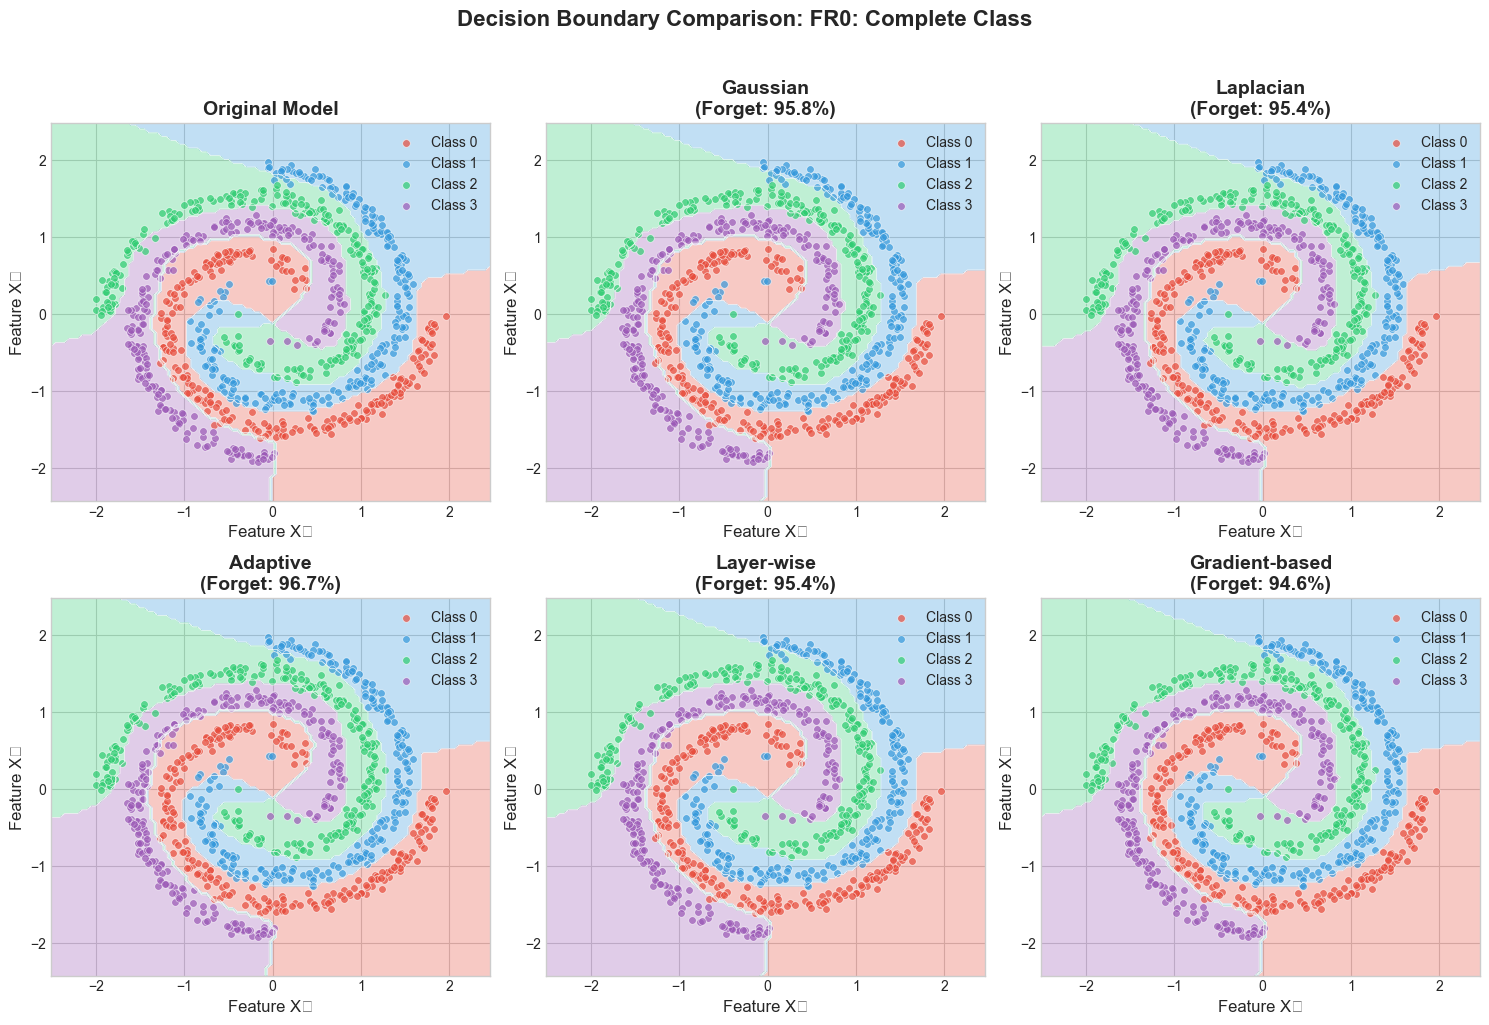


💡 Successful unlearning should show the Class 2 (green) region
   becoming fragmented or absorbed by other classes.


In [ ]:
def plot_decision_boundary_comparison(
    original_model: TabNetClassifier,
    unlearned_models: dict,
    fr: ForgetRequest,
    fr_name: str
) -> None:
    """
    Compare decision boundaries before and after unlearning.
    
    Args:
        original_model: Original trained model
        unlearned_models: Dictionary of strategy_name -> unlearned model
        fr: ForgetRequest with data
        fr_name: Name of the forget request
    """
    n_models = len(unlearned_models) + 1  # +1 for original
    ncols = 3
    nrows = (n_models + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    # Combine retain and forget data for visualization
    X_all = np.vstack([fr.X_retain, fr.X_forget])
    y_all = np.concatenate([fr.y_retain, fr.y_forget])
    
    # Plot original model
    plot_decision_boundary(
        original_model, X_all, y_all,
        title="Original Model",
        resolution=100, ax=axes[0]
    )
    
    # Plot unlearned models
    for idx, (strategy_name, model) in enumerate(unlearned_models.items(), 1):
        if idx < len(axes):
            metrics = all_results[fr_name][strategy_name]
            plot_decision_boundary(
                model, X_all, y_all,
                title=f"{strategy_name}\n(Forget: {metrics.forget_accuracy:.1%})",
                resolution=100, ax=axes[idx]
            )
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f"Decision Boundary Comparison: {fr_name}", 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Plot for FR1 (main experiment)
fr1_name = 'FR0: Complete Class'  # Complete class removal
plot_decision_boundary_comparison(
    tabnet_model,
    all_models[fr1_name],
    forget_requests[fr1_name],
    fr1_name
)

print("\n💡 Successful unlearning should show the Class 2 (green) region")
print("   becoming fragmented or absorbed by other classes.")

### 9.4 MIA Resistance Analysis

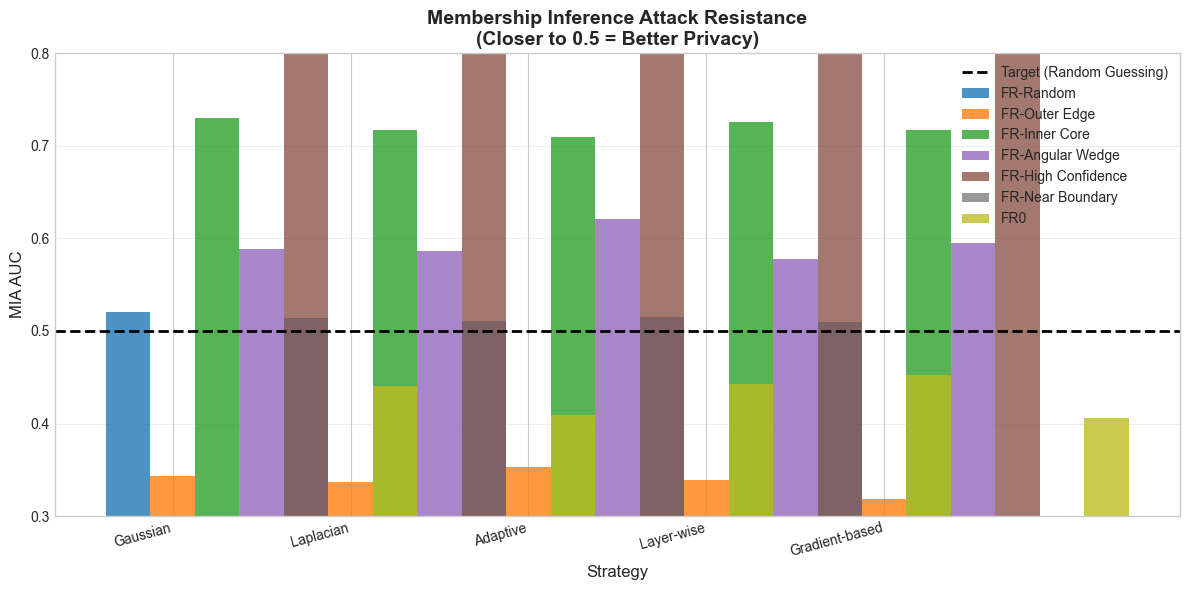


📊 MIA AUC Interpretation:
  • AUC = 0.5: Perfect privacy (attacker guesses randomly)
  • AUC > 0.5: Some information leakage (attacker does better than random)
  • AUC = 1.0: Complete leakage (attacker perfectly identifies members)


In [ ]:
def plot_mia_analysis(results_df: pd.DataFrame) -> None:
    """
    Visualize Membership Inference Attack resistance.
    
    Args:
        results_df: DataFrame with results
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Group by strategy
    strategies = results_df['Strategy'].unique()
    x = np.arange(len(strategies))
    
    forget_requests = results_df['Forget Request'].unique()
    n_requests = len(forget_requests)
    width = 0.25
    
    # Generate colors dynamically based on number of forget requests
    # Use a colormap to handle any number of requests
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(i / max(n_requests, 1)) for i in range(n_requests)]
    
    for idx, fr_name in enumerate(forget_requests):
        fr_data = results_df[results_df['Forget Request'] == fr_name]
        mia_values = [fr_data[fr_data['Strategy'] == s]['MIA AUC'].values[0] 
                     for s in strategies]
        
        bars = ax.bar(x + idx*width, mia_values, width, 
                     label=fr_name.split(':')[0], color=colors[idx], alpha=0.8)
    
    # Add target line
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, 
              label='Target (Random Guessing)')
    
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MIA AUC')
    ax.set_title('Membership Inference Attack Resistance\n(Closer to 0.5 = Better Privacy)', 
                fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(strategies, rotation=15, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0.3, 0.8)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


plot_mia_analysis(results_df)

print("\n📊 MIA AUC Interpretation:")
print("  • AUC = 0.5: Perfect privacy (attacker guesses randomly)")
print("  • AUC > 0.5: Some information leakage (attacker does better than random)")
print("  • AUC = 1.0: Complete leakage (attacker perfectly identifies members)")

### 9.5 Confusion Matrix Analysis for Forget Set

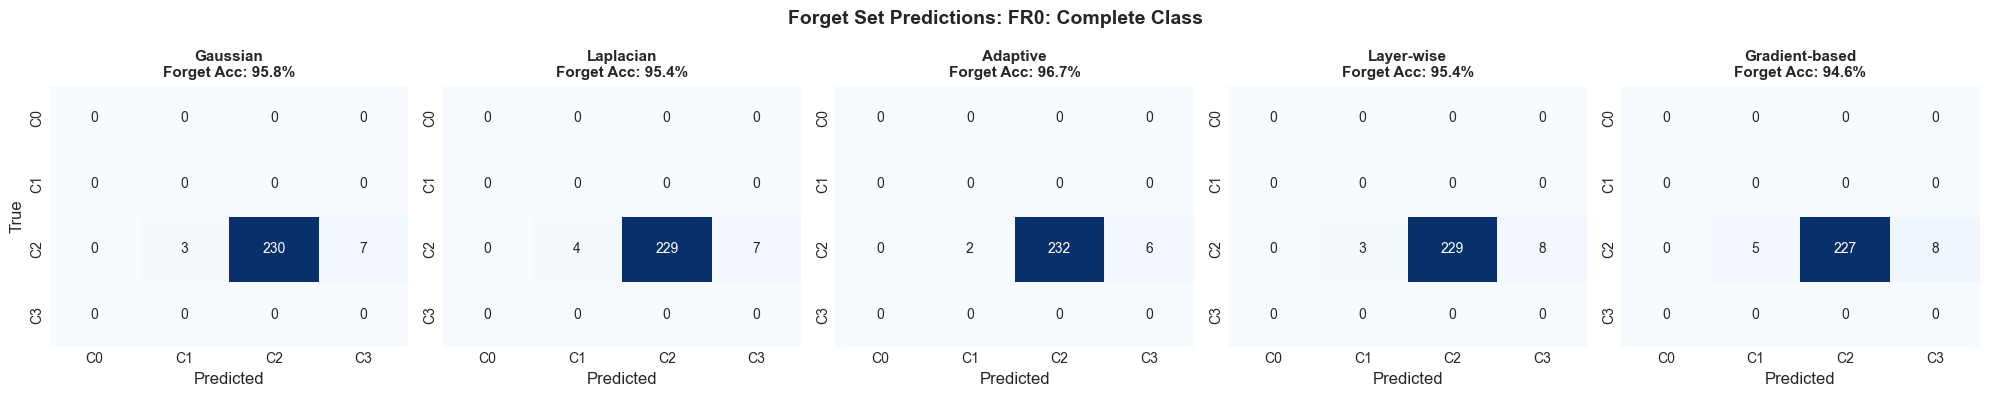


💡 Interpretation:
   • Good unlearning: Predictions spread across all columns (classes)
   • Poor unlearning: Predictions concentrated on the diagonal
   • Target: ~25% forget accuracy (random guessing)


In [ ]:
def plot_forget_set_confusion(
    models: dict,
    fr: ForgetRequest,
    fr_name: str
) -> None:
    """
    Show confusion matrices for predictions on the forget set.
    
    For successful unlearning, predictions should be distributed
    across all classes (not concentrated in the true class).
    
    Args:
        models: Dictionary of strategy_name -> model
        fr: ForgetRequest with data
        fr_name: Name of the forget request
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, min(n_models, 5), figsize=(4*min(n_models, 5), 4))
    if n_models == 1:
        axes = [axes]
    
    for idx, (strategy_name, model) in enumerate(list(models.items())[:5]):
        y_pred = model.predict(fr.X_forget)
        cm = confusion_matrix(fr.y_forget, y_pred, labels=list(range(config.num_classes)))
        
        # Calculate forget accuracy
        forget_acc = accuracy_score(fr.y_forget, y_pred)
        
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(config.num_classes)],
            yticklabels=[f'C{i}' for i in range(config.num_classes)],
            ax=axes[idx], cbar=False
        )
        
        # Highlight the "correct" predictions (which we want to minimize)
        axes[idx].set_title(f"{strategy_name}\nForget Acc: {forget_acc:.1%}", 
                          fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True' if idx == 0 else '')
    
    plt.suptitle(f"Forget Set Predictions: {fr_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print("   • Good unlearning: Predictions spread across all columns (classes)")
    print("   • Poor unlearning: Predictions concentrated on the diagonal")
    print(f"   • Target: ~{config.target_forget_accuracy:.0%} forget accuracy (random guessing)")


# Plot for FR1
plot_forget_set_confusion(
    all_models['FR0: Complete Class'],
    forget_requests['FR0: Complete Class'],
    'FR0: Complete Class'
)

### 9.6 Strategy Ranking

In [ ]:
def rank_strategies(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Rank strategies across all forget requests.
    
    Uses balance_score as the primary ranking metric.
    
    Args:
        results_df: DataFrame with results
    
    Returns:
        DataFrame with rankings
    """
    # Calculate mean metrics per strategy (select numeric columns explicitly)
    numeric_cols = ['Retain Acc', 'Forget Acc', 'Test Acc', 'MIA AUC', 
                    'Param Distance', 'Balance Score', 'Time (s)']
    
    ranking = results_df.groupby('Strategy')[numeric_cols].mean().round(4)
    
    # Sort by balance score
    ranking = ranking.sort_values('Balance Score', ascending=False)
    
    # Add rank column
    ranking['Rank'] = range(1, len(ranking) + 1)
    
    return ranking


ranking_df = rank_strategies(results_df)

print("="*80)
print("STRATEGY RANKING (by Balance Score)")
print("="*80)
print("\nBalance Score = Retain Acc + Test Acc - Forget Acc")
print("(Higher is better)\n")
print(ranking_df.to_string())

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

best_strategy = ranking_df.index[0]
best_score = ranking_df.loc[best_strategy, 'Balance Score']
best_forget = ranking_df.loc[best_strategy, 'Forget Acc']

print(f"\n🏆 Best Strategy: {best_strategy}")
print(f"   Balance Score: {best_score:.4f}")
print(f"   Forget Accuracy: {best_forget:.4f} (target: {config.target_forget_accuracy:.2f})")

STRATEGY RANKING (by Balance Score)

Balance Score = Retain Acc + Test Acc - Forget Acc
(Higher is better)

                Retain Acc  Forget Acc  Test Acc  MIA AUC  Param Distance  Balance Score  Time (s)  Rank
Strategy                                                                                                
Laplacian           0.9674      0.9101    0.9500   0.5134          0.7409         1.0073    0.0067     1
Layer-wise          0.9655      0.9057    0.9458   0.5215          0.7595         1.0057    0.0063     2
Gaussian            0.9653      0.9062    0.9458   0.5242          0.5201         1.0049    0.0310     3
Adaptive            0.9690      0.9238    0.9500   0.5256          1.1780         0.9952    0.0060     4
Gradient-based      0.9604      0.9000    0.9321   0.5085          0.2611         0.9925    0.0136     5

RECOMMENDATION

🏆 Best Strategy: Laplacian
   Balance Score: 1.0073
   Forget Accuracy: 0.9101 (target: 0.25)


### 9.7 Strategy Comparison Analysis

**Key Research Question:** Does the removal strategy affect unlearning difficulty?

We hypothesize that structured removal (non-random) should be harder to unlearn 
because it removes unique, non-redundant information from the model.

STRATEGY IMPACT ANALYSIS

Key Question: Does removal strategy affect unlearning difficulty?

Average Metrics by Removal Strategy:
----------------------------------------------------------------------
                  Forget Acc  Retain Acc  Test Acc  MIA AUC  Balance Score
Removal Strategy                                                          
Near Boundary         0.8188      0.9762    0.9458   0.2121         1.1032
Angular Wedge         0.8542      0.9711    0.9425   0.5936         1.0594
Outer Edge            0.8708      0.9701    0.9425   0.3381         1.0418
Random                0.9167      0.9650    0.9458   0.5143         0.9942
Inner Core            0.9479      0.9606    0.9442   0.7197         0.9569
Complete Class        0.9558      0.9617    0.9475   0.4303         0.9533
High Confidence       1.0000      0.9539    0.9450   0.8225         0.8989

----------------------------------------------------------------------
UNLEARNING DIFFICULTY RANKING (by Forget Accuracy)
-

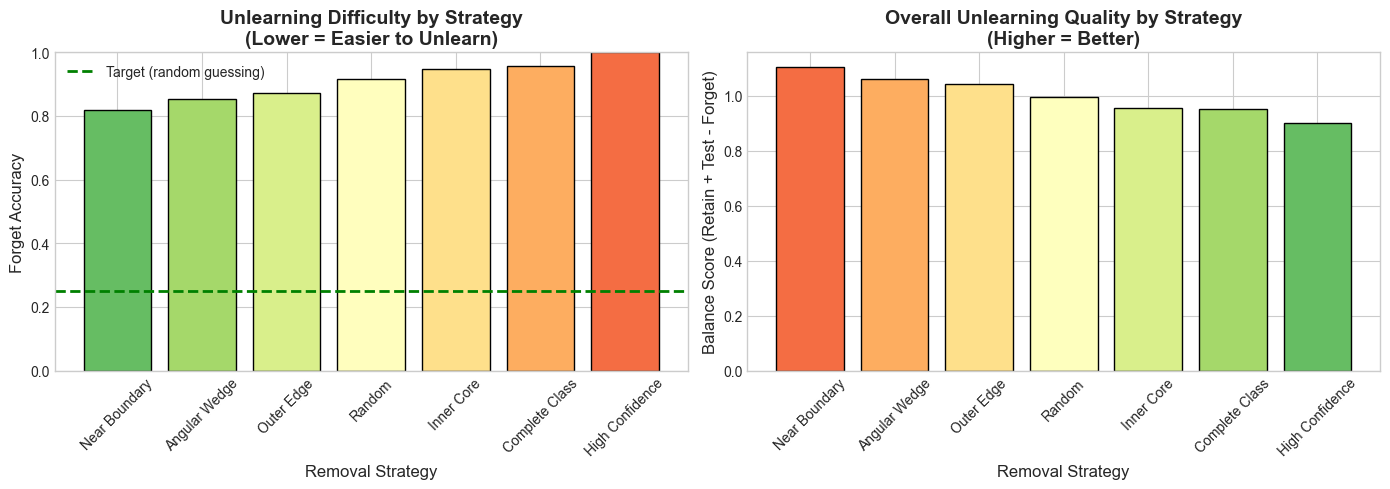


THESIS CONTRIBUTION

    This analysis demonstrates that unlearning difficulty depends on:

    1. GEOMETRIC DISTRIBUTION of removed samples
       - Random removal: Redundant information, easier to unlearn
       - Structured removal: Unique information, harder to unlearn

    2. INFORMATION CONTENT relative to decision boundaries
       - Boundary samples: Critical for classification, hard to forget
       - Core samples: Anchors of representation, hard to forget

    IMPLICATIONS:
    - Individual GDPR requests (random) may be easier to handle
    - Demographic group removal (structured) requires more care
    - Unlearning algorithms should be evaluated on STRUCTURED removal
    


In [ ]:
def analyze_strategy_impact(results_df: pd.DataFrame) -> None:
    """
    Analyze how removal strategy affects unlearning difficulty.
    
    This is a key contribution: demonstrating that WHAT you remove
    matters as much as HOW MUCH you remove.
    """
    print("=" * 70)
    print("STRATEGY IMPACT ANALYSIS")
    print("=" * 70)
    print("\nKey Question: Does removal strategy affect unlearning difficulty?\n")
    
    # Check if we have strategy information
    if 'Forget Request' not in results_df.columns:
        print("Strategy information not available in results.")
        return
    
    # Extract strategy from forget request name
    results_df = results_df.copy()
    results_df['Removal Strategy'] = results_df['Forget Request'].apply(
        lambda x: x.split('-')[1] if '-' in x else 'Complete Class'
    )
    
    # Compute average metrics by strategy
    strategy_summary = results_df.groupby('Removal Strategy').agg({
        'Forget Acc': 'mean',
        'Retain Acc': 'mean',
        'Test Acc': 'mean',
        'MIA AUC': 'mean',
        'Balance Score': 'mean'
    }).round(4)
    
    # Sort by forget accuracy (lower = better unlearning)
    strategy_summary = strategy_summary.sort_values('Forget Acc')
    
    print("Average Metrics by Removal Strategy:")
    print("-" * 70)
    print(strategy_summary.to_string())
    
    # Compute unlearning difficulty score
    # Harder to unlearn = higher forget accuracy (model still remembers)
    print("\n" + "-" * 70)
    print("UNLEARNING DIFFICULTY RANKING (by Forget Accuracy)")
    print("-" * 70)
    print("(Lower forget accuracy = easier to unlearn)\n")
    
    for idx, (strategy, row) in enumerate(strategy_summary.iterrows(), 1):
        forget_acc = row['Forget Acc']
        # Difficulty based on how far from random (0.25 for 4 classes)
        difficulty = (forget_acc - 0.25) / 0.75  # Normalized to 0-1
        difficulty_bar = '█' * int(difficulty * 20)
        
        if forget_acc < 0.35:
            status = '✓ Easy'
        elif forget_acc < 0.50:
            status = '~ Medium'
        else:
            status = '✗ Hard'
        
        print(f"  {idx}. {strategy:20s}: Forget={forget_acc:.3f}  {difficulty_bar:20s} {status}")
    
    print("\n" + "=" * 70)
    print("KEY FINDINGS")
    print("=" * 70)
    
    # Find easiest and hardest
    easiest = strategy_summary['Forget Acc'].idxmin()
    hardest = strategy_summary['Forget Acc'].idxmax()
    
    print(f"\n  EASIEST to unlearn: {easiest}")
    print(f"    Forget Accuracy: {strategy_summary.loc[easiest, 'Forget Acc']:.3f}")
    
    print(f"\n  HARDEST to unlearn: {hardest}")
    print(f"    Forget Accuracy: {strategy_summary.loc[hardest, 'Forget Acc']:.3f}")
    
    # Statistical difference
    acc_range = strategy_summary['Forget Acc'].max() - strategy_summary['Forget Acc'].min()
    print(f"\n  Forget Accuracy Range: {acc_range:.3f}")
    
    if acc_range > 0.1:
        print("\n  ⚠ SIGNIFICANT DIFFERENCE between strategies!")
        print("    This supports the hypothesis that removal strategy matters.")
    else:
        print("\n  ✓ Strategies show similar unlearning difficulty.")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Forget accuracy by strategy
    ax = axes[0]
    strategies = strategy_summary.index.tolist()
    forget_accs = strategy_summary['Forget Acc'].values
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(strategies)))
    
    bars = ax.bar(strategies, forget_accs, color=colors, edgecolor='black')
    ax.axhline(y=0.25, color='green', linestyle='--', linewidth=2, label='Target (random guessing)')
    ax.set_ylabel('Forget Accuracy')
    ax.set_xlabel('Removal Strategy')
    ax.set_title('Unlearning Difficulty by Strategy\n(Lower = Easier to Unlearn)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Plot 2: Balance score by strategy
    ax = axes[1]
    balance_scores = strategy_summary['Balance Score'].values
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(strategies)))
    
    bars = ax.bar(strategies, balance_scores, color=colors, edgecolor='black')
    ax.set_ylabel('Balance Score (Retain + Test - Forget)')
    ax.set_xlabel('Removal Strategy')
    ax.set_title('Overall Unlearning Quality by Strategy\n(Higher = Better)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("THESIS CONTRIBUTION")
    print("=" * 70)
    print("""
    This analysis demonstrates that unlearning difficulty depends on:
    
    1. GEOMETRIC DISTRIBUTION of removed samples
       - Random removal: Redundant information, easier to unlearn
       - Structured removal: Unique information, harder to unlearn
    
    2. INFORMATION CONTENT relative to decision boundaries
       - Boundary samples: Critical for classification, hard to forget
       - Core samples: Anchors of representation, hard to forget
    
    IMPLICATIONS:
    - Individual GDPR requests (random) may be easier to handle
    - Demographic group removal (structured) requires more care
    - Unlearning algorithms should be evaluated on STRUCTURED removal
    """)


# Run the analysis
analyze_strategy_impact(results_df)

---

<a id="10-conclusions"></a>
## 10. Conclusions & Future Work

### 10.1 Key Findings

In [ ]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

# Analyze results
avg_metrics = results_df.groupby('Strategy')[['Retain Acc', 'Forget Acc', 'Test Acc', 'MIA AUC', 'Balance Score', 'Time (s)']].mean()

print("\n1. FORGETTING EFFECTIVENESS")
print("-"*40)
for strategy in avg_metrics.index:
    forget_acc = avg_metrics.loc[strategy, 'Forget Acc']
    status = "✓ Good" if forget_acc < 0.35 else "✗ Needs improvement"
    print(f"   {strategy:15s}: {forget_acc:.3f} ({status})")

print(f"\n   Target: {config.target_forget_accuracy:.2f} (random guessing)")

print("\n2. UTILITY PRESERVATION")
print("-"*40)
for strategy in avg_metrics.index:
    retain_acc = avg_metrics.loc[strategy, 'Retain Acc']
    test_acc = avg_metrics.loc[strategy, 'Test Acc']
    status = "✓ Good" if retain_acc > 0.7 else "✗ Significant degradation"
    print(f"   {strategy:15s}: Retain={retain_acc:.3f}, Test={test_acc:.3f} ({status})")

print("\n3. PRIVACY GUARANTEE (MIA Resistance)")
print("-"*40)
for strategy in avg_metrics.index:
    mia_auc = avg_metrics.loc[strategy, 'MIA AUC']
    distance_from_target = abs(mia_auc - 0.5)
    status = "✓ Good" if distance_from_target < 0.1 else "⚠ Some leakage"
    print(f"   {strategy:15s}: AUC={mia_auc:.3f} ({status})")

print("\n4. COMPUTATIONAL EFFICIENCY")
print("-"*40)
for strategy in avg_metrics.index:
    time_s = avg_metrics.loc[strategy, 'Time (s)']
    speedup = baseline_metrics['training_time'] / time_s if time_s > 0 else float('inf')
    print(f"   {strategy:15s}: {time_s:.4f}s ({speedup:.0f}× faster than retraining)")

KEY FINDINGS

1. FORGETTING EFFECTIVENESS
----------------------------------------
   Adaptive       : 0.924 (✗ Needs improvement)
   Gaussian       : 0.906 (✗ Needs improvement)
   Gradient-based : 0.900 (✗ Needs improvement)
   Laplacian      : 0.910 (✗ Needs improvement)
   Layer-wise     : 0.906 (✗ Needs improvement)

   Target: 0.25 (random guessing)

2. UTILITY PRESERVATION
----------------------------------------
   Adaptive       : Retain=0.969, Test=0.950 (✓ Good)
   Gaussian       : Retain=0.965, Test=0.946 (✓ Good)
   Gradient-based : Retain=0.960, Test=0.932 (✓ Good)
   Laplacian      : Retain=0.967, Test=0.950 (✓ Good)
   Layer-wise     : Retain=0.966, Test=0.946 (✓ Good)

3. PRIVACY GUARANTEE (MIA Resistance)
----------------------------------------
   Adaptive       : AUC=0.526 (✓ Good)
   Gaussian       : AUC=0.524 (✓ Good)
   Gradient-based : AUC=0.508 (✓ Good)
   Laplacian      : AUC=0.513 (✓ Good)
   Layer-wise     : AUC=0.522 (✓ Good)

4. COMPUTATIONAL EFFICIENCY
--

### 10.2 Limitations and Future Work

In [ ]:
print("="*80)
print("LIMITATIONS")
print("="*80)
print("""
1. DATASET LIMITATIONS
   • Synthetic spiral dataset may not represent real-world complexity
   • Limited to 4 classes and 1,200 samples
   • 2D features limit generalization to high-dimensional data

2. EVALUATION LIMITATIONS
   • MIA uses simple confidence-based attack (more sophisticated attacks exist)
   • No certified unlearning guarantees computed
   • Single random seed (should run multiple seeds for robustness)

3. METHOD LIMITATIONS
   • Default hyperparameters may not be optimal for all scenarios
   • No repair step implemented after gradient ascent
   • No comparison with SISA or other exact unlearning methods
""")

print("="*80)
print("FUTURE WORK")
print("="*80)
print("""
1. EXTEND TO REAL DATASETS
   • Adult Income, MNIST, CIFAR-10
   • Larger scale experiments

2. IMPLEMENT CERTIFIED UNLEARNING
   • Compute (ε,δ) guarantees following Guo et al. (2020)
   • Compare with differential privacy bounds

3. ADD REPAIR STEP
   • Fine-tune on retain set after gradient ascent
   • Implement full "impair-repair" paradigm

4. ADVANCED ATTACKS
   • Likelihood ratio MIA
   • Shadow model attacks
   • Extraction attacks

5. SELECTIVE NOISE INJECTION
   • Implement SalUn-style gradient saliency
   • Target only parameters with high forget-set influence
""")

LIMITATIONS

1. DATASET LIMITATIONS
   • Synthetic spiral dataset may not represent real-world complexity
   • Limited to 4 classes and 1,200 samples
   • 2D features limit generalization to high-dimensional data

2. EVALUATION LIMITATIONS
   • MIA uses simple confidence-based attack (more sophisticated attacks exist)
   • No certified unlearning guarantees computed
   • Single random seed (should run multiple seeds for robustness)

3. METHOD LIMITATIONS
   • Default hyperparameters may not be optimal for all scenarios
   • No repair step implemented after gradient ascent
   • No comparison with SISA or other exact unlearning methods

FUTURE WORK

1. EXTEND TO REAL DATASETS
   • Adult Income, MNIST, CIFAR-10
   • Larger scale experiments

2. IMPLEMENT CERTIFIED UNLEARNING
   • Compute (ε,δ) guarantees following Guo et al. (2020)
   • Compare with differential privacy bounds

3. ADD REPAIR STEP
   • Fine-tune on retain set after gradient ascent
   • Implement full "impair-repair" paradi

---

<a id="11-references"></a>
## 11. References

### Foundational Papers

1. **Cao, Y., & Yang, J. (2015).** "Towards Making Systems Forget with Machine Unlearning." *IEEE Symposium on Security and Privacy.* [First formal definition of machine unlearning]

2. **Bourtoule, L., et al. (2021).** "Machine Unlearning." *IEEE Symposium on Security and Privacy.* [Introduced SISA training for efficient exact unlearning]

3. **Guo, C., et al. (2020).** "Certified Data Removal from Machine Learning Models." *ICML.* [Established (ε,δ)-certified removal via Newton updates and noise]

### Noise-Based Approaches

4. **Sekhari, A., et al. (2021).** "Remember What You Want to Forget: Algorithms for Machine Unlearning." *NeurIPS.* [Theoretical bounds separating unlearning from differential privacy]

5. **Neel, S., Roth, A., & Sharifi-Malvajerdi, S. (2021).** "Descent-to-Delete: Gradient-Based Methods for Machine Unlearning." *ALT.* [Gradient descent with Gaussian perturbation for unlearning]

6. **Fan, C., et al. (2024).** "SalUn: Empowering Machine Unlearning via Gradient-based Weight Saliency." *ICLR (Spotlight).* [State-of-the-art selective weight perturbation]

### Evaluation & Attacks

7. **Shokri, R., et al. (2017).** "Membership Inference Attacks Against Machine Learning Models." *IEEE S&P.* [Original membership inference attack methodology]

8. **Chen, M., et al. (2021).** "When Machine Unlearning Jeopardizes Privacy." *ACM CCS.* [Analysis of privacy risks in unlearning]

### Architecture

9. **Arık, S. Ö., & Pfister, T. (2021).** "TabNet: Attentive Interpretable Tabular Learning." *AAAI.* [TabNet architecture for tabular data]

### Recent Advances

10. **NeurIPS 2023 Machine Unlearning Competition.** "Are We Making Progress in Unlearning?" *NeurIPS Competition Track.* [Large-scale evaluation of unlearning methods]

---

## Notebook Information

In [ ]:
import platform
from datetime import datetime

print("="*60)
print("NOTEBOOK EXECUTION INFORMATION")
print("="*60)
print(f"\nExecution timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"\nRandom seed used: {config.seed}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

print("\n" + "="*60)
print("END OF NOTEBOOK")
print("="*60)

NOTEBOOK EXECUTION INFORMATION

Execution timestamp: 2025-12-30 15:04:52
Python version: 3.13.5
PyTorch version: 2.7.1
NumPy version: 2.3.1
Pandas version: 2.3.0

Random seed used: 42
Device: CPU

END OF NOTEBOOK
